In [1]:
import os
import argparse
import time
import datetime
from tqdm import tqdm

from munch import Munch
from torch.backends import cudnn
import torch
import torch.nn.functional as F
import numpy as np

from core.my_loader import get_train_loader, get_test_loader, InputFetcher
from core.my_solver import Solver
from torchvision.transforms import Compose, Resize, Normalize, ToTensor
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset, DataLoader

from easydict import EasyDict as edict
from core.my_solver import compute_d_loss, compute_g_loss, moving_average, adv_loss, r1_reg, Sampler, LoaderSampler, tensor2img
from core.my_metrics import get_Z_pushed_loader_stats, calculate_cost
from core.fid_score import calculate_frechet_distance

from IPython.display import clear_output
import matplotlib.pyplot as plt

os.environ['CUDA_VISIBLE_DEVICES'] = "4"

def str2bool(v):
    return v.lower() in ('true')


def subdirs(dname):
    return [d for d in os.listdir(dname)
            if os.path.isdir(os.path.join(dname, d))]

lambda_id = 100.0

args = edict({
    'img_size': 64,
    'num_domains': 2,
    'latent_dim': 16,
    'hidden_dim': 512,
    'style_dim': 64, 
    'lambda_reg': 1.0,
    'lambda_cyc': 1.0,
    'lambda_sty': 1.0,
    'lambda_ds': 1.0,
    'lambda_id': lambda_id,
    'ds_iter': 100000,
    'w_hpf': -1.0,
    'randcrop_prob': 0.5,
    'total_iters': 100000,
    'resume_iter': 0,
    'batch_size': 16,
    'val_batch_size': 32,
    'lr': 1e-4,
    'f_lr': 1e-6,
    'beta1': 0.0,
    'beta2': 0.99,
    'weight_decay': 1e-4,
    'num_outs_per_domain': 10,
    'mode': 'train', 
    'num_workers': 4,
    'seed': 777,
    'train_img_dir': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_train',
    'val_img_dir': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_test',
    'sample_dir': 'expr/samples',
    'checkpoint_dir': f'/cache/selikhanovych/OT_competitors/stargan-v2/celeba2anime_exps/checkpoints_lambda_{lambda_id}',
    'eval_dir': 'expr/eval',
    'result_dir': 'expr/results',
    'src_dir': 'assets/representative/celeba_hq/src',
    'ref_dir': 'assets/representative/celeba_hq/ref',
    'inp_dir': 'assets/representative/custom/female',
    'out_dir': 'assets/representative/celeba_hq/src/female',
    'wing_path': 'expr/checkpoints/wing.ckpt',
    'lm_path': 'expr/checkpoints/celeba_lm_mean.npz',
    'print_every': 10,
    'sample_every': 4000,
    'save_every': 4000,
    'eval_every': 4000,
    
    'target_dataset': 'aligned_anime_faces',
    'OUTPUT_PATH': f'/cache/selikhanovych/OT_competitors/stargan-v2/celeba2anime_exps/checkpoints_lambda_{lambda_id}',
    'domains': {
        'source': 'celeba_female',
        'target': 'aligned_anime_faces',
    },
    'train_a': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_train/celeba_female',
    'train_b': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_train/aligned_anime_faces', 
    'test_a': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_test/celeba_female',
    'test_b': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_test/aligned_anime_faces',
    
    'n_epochs': 1
})

os.system(f"mkdir -p {args.OUTPUT_PATH}")
os.system(f"mkdir -p {args.checkpoint_dir}")


eval_trg_domain = args.domains['target']
eval_src_domain = args.domains['source']

domains = os.listdir(args.val_img_dir)
domains.sort()

final_trg_index = -1
final_src_index = -1

for trg_idx, trg_domain in enumerate(domains):
    src_domains = [x for x in domains if x != trg_domain]
    for src_idx, src_domain in enumerate(src_domains):
        if src_domain == eval_src_domain and trg_domain == eval_trg_domain:
            final_trg_index = trg_idx
            final_src_index = src_idx
            
print(final_trg_index, final_src_index)

cudnn.benchmark = True
torch.manual_seed(args.seed)

solver = Solver(args)

assert len(subdirs(args.train_img_dir)) == args.num_domains
assert len(subdirs(args.val_img_dir)) == args.num_domains

loaders = Munch(src=get_train_loader(root=args.train_img_dir,
                                     which='source',
                                     img_size=args.img_size,
                                     batch_size=args.batch_size,
                                     num_workers=args.num_workers),
                ref=get_train_loader(root=args.train_img_dir,
                                     which='reference',
                                     img_size=args.img_size,
                                     batch_size=args.batch_size,
                                     num_workers=args.num_workers),
                val=get_test_loader(root=args.val_img_dir,
                                    img_size=args.img_size,
                                    batch_size=args.val_batch_size,
                                    shuffle=False,
                                    num_workers=args.num_workers))

device = 'cuda'

args = solver.args
nets = solver.nets
nets_ema = solver.nets_ema
optims = solver.optims

transform = Compose([Resize((args.img_size, args.img_size)),
                     ToTensor(),
                     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset_a = ImageFolder(args.train_a, transform)
train_dataset_b = ImageFolder(args.train_b, transform)
test_dataset_a = ImageFolder(args.test_a, transform)
test_dataset_b = ImageFolder(args.test_b, transform)

train_loader_a = DataLoader(dataset=train_dataset_a,
                            batch_size=20,
                            num_workers=4,
                            pin_memory=True,
                            shuffle=False)

train_loader_b = DataLoader(dataset=train_dataset_b,
                            batch_size=20,
                            num_workers=4,
                            pin_memory=True,
                            shuffle=False)

test_loader_a = DataLoader(dataset=test_dataset_a,
                           batch_size=20,
                           num_workers=4,
                           pin_memory=True,
                           shuffle=False)

test_loader_b = DataLoader(dataset=test_dataset_b,
                           batch_size=20,
                           num_workers=4,
                           pin_memory=True,
                           shuffle=False)

X_sampler = LoaderSampler(train_loader_a)
X_test_sampler = LoaderSampler(test_loader_a)
Y_sampler = LoaderSampler(train_loader_b)
Y_test_sampler = LoaderSampler(test_loader_b)


torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)
solver.X_fixed = X_sampler.sample(10)
solver.Y_fixed = Y_sampler.sample(10)

solver.X_test_fixed = X_test_sampler.sample(10)
solver.Y_test_fixed = Y_test_sampler.sample(10)

# fetch random validation images for debugging
fetcher = InputFetcher(loaders.src, loaders.ref, args.latent_dim, 'train')
fetcher_val = InputFetcher(loaders.val, None, args.latent_dim, 'val')
inputs_val = next(fetcher_val)

# resume training if necessary
if args.resume_iter > 0:
    solver._load_checkpoint(args.resume_iter)

# remember the initial value of ds weight
initial_lambda_ds = args.lambda_ds

eval_trg_domain = args.domains['target']
eval_src_domain = args.domains['source']

domains = os.listdir(args.val_img_dir)
domains.sort()
num_domains = len(domains)
for trg_idx, trg_domain in enumerate(domains):
    src_domains = [x for x in domains if x != trg_domain]
    for src_idx, src_domain in enumerate(src_domains):
        if src_domain == eval_src_domain and trg_domain == eval_trg_domain:
            print(f"trg_idx = {trg_idx}, trg_domain = {trg_domain}, src_domain = {src_domain}")
            break
    break
                    
print(f"trg_idx = {trg_idx}, lambda_id = {args.lambda_id}")

0 0
Number of parameters of generator: 32634883
Number of parameters of mapping_network: 2438272
Number of parameters of style_encoder: 20327808
Number of parameters of discriminator: 20263170
Initializing generator...
Initializing mapping_network...
Initializing style_encoder...
Initializing discriminator...
Preparing DataLoader to fetch source images during the training phase...
Preparing DataLoader to fetch reference images during the training phase...
Preparing DataLoader for the generation phase...
trg_idx = 0, trg_domain = aligned_anime_faces, src_domain = celeba_female
trg_idx = 0, lambda_id = 100.0


Computing l1 cost


591it [00:29, 20.35it/s]


l1 cost = 0.03538673329712494, best l1 cost = 0.03509909559744956, best iter = 92000
Computing l2 cost


591it [00:29, 20.15it/s]


l2 cost = 0.004420392644026026, best l2 cost = 0.003945945796462819, best iter = 68000
Computing FID
Calculating evaluation metrics...
Number of domains: 2
Compute FID for celeba_female2aligned_anime_faces, trg_idx = 0, trg_domain = aligned_anime_faces
Preparing DataLoader for the generation phase...


100%|██████████| 320/320 [00:39<00:00,  8.03it/s]


FID = 125.27211420733829, best FID = 123.61365593486948, best iter = 20000
FID = 125.27211420733829, best FID = 123.61365593486948, best iter = 20000
Plotting, iter = 96000
mode = train


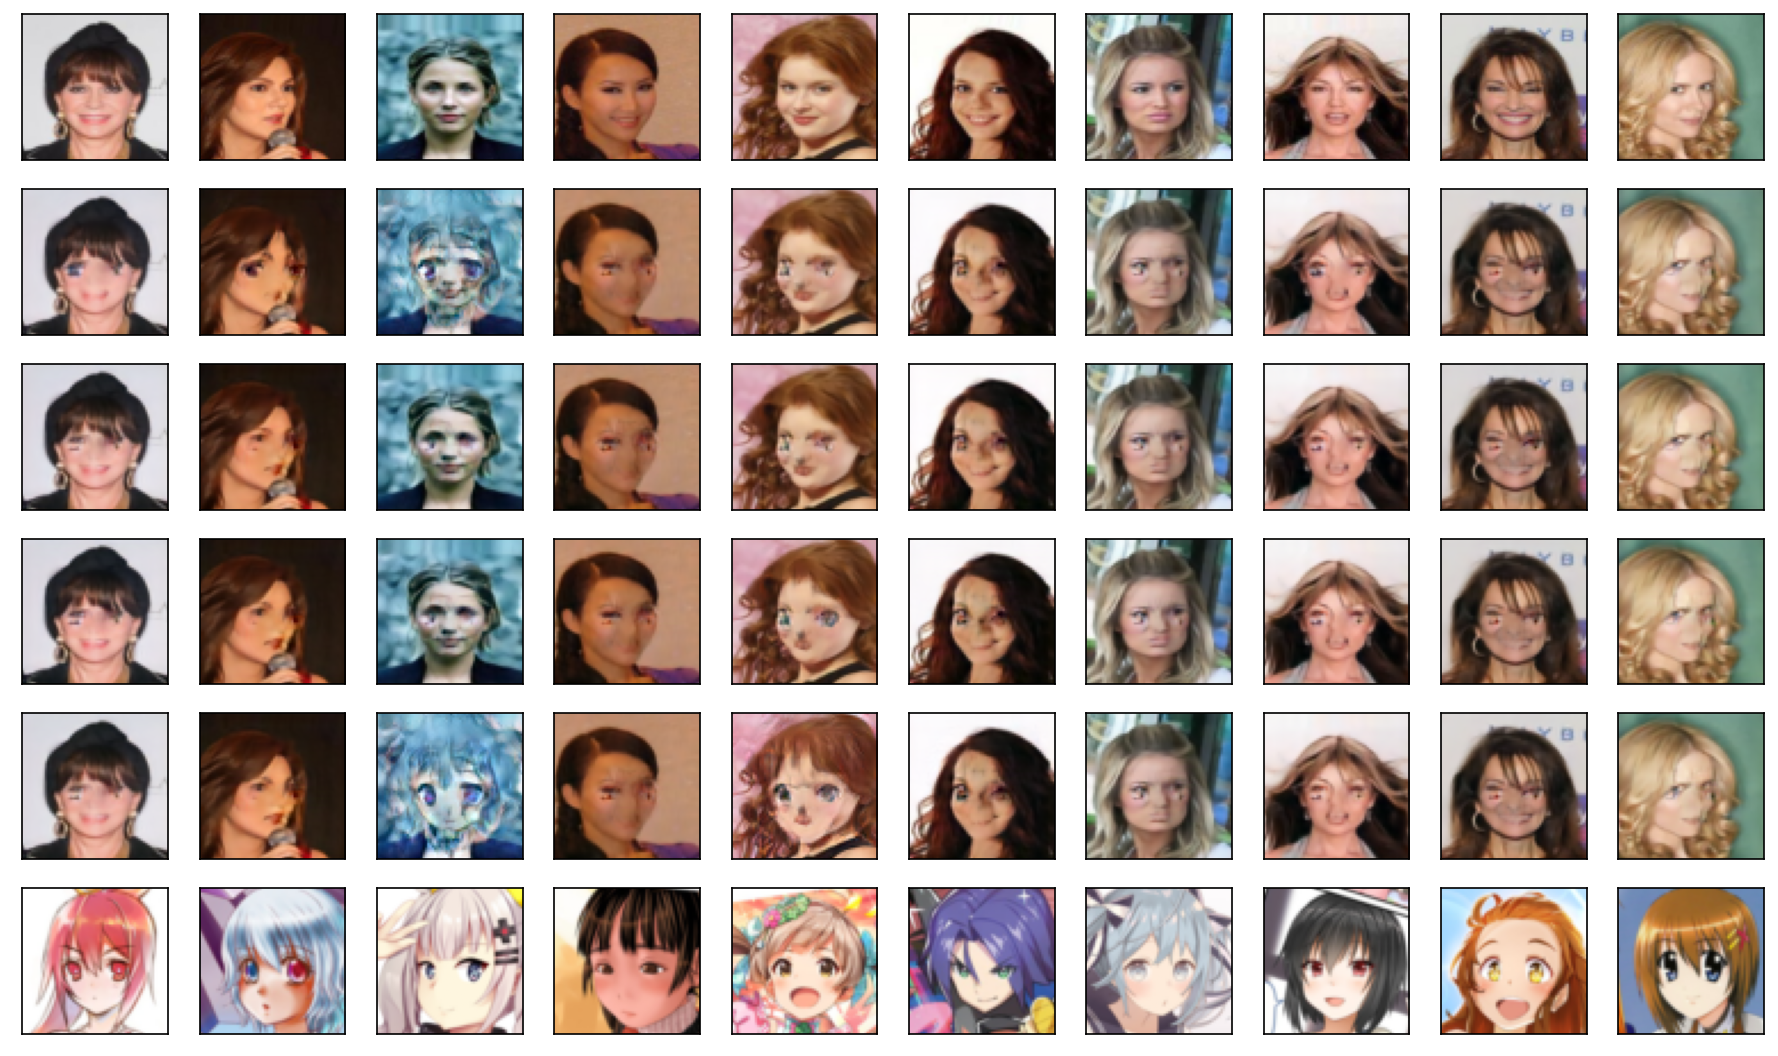

mode = test


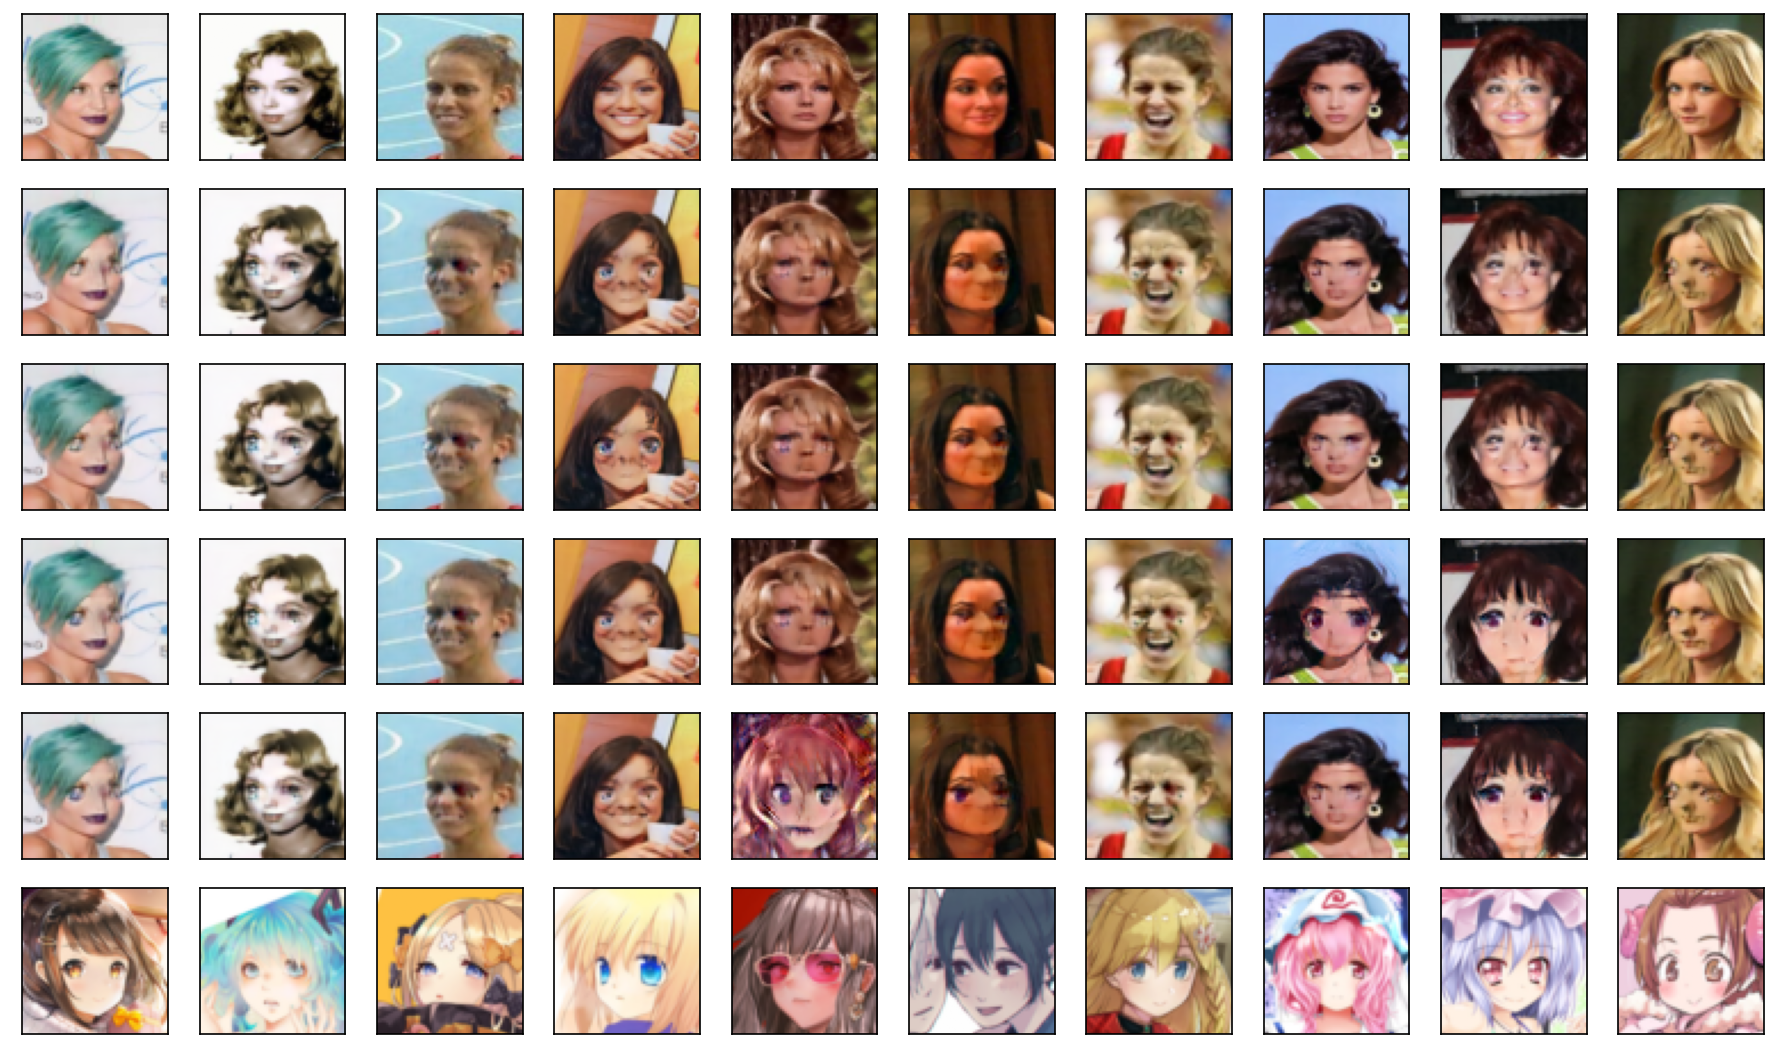

G loss = 6.431166172027588, d loss = 1.1522393226623535, lambda_id = 100.0
G loss = 7.470352649688721, d loss = 0.9193639159202576, lambda_id = 100.0
G loss = 7.732159614562988, d loss = 0.8576698899269104, lambda_id = 100.0
G loss = 6.832505226135254, d loss = 1.0058549642562866, lambda_id = 100.0
G loss = 7.070895195007324, d loss = 1.0127363204956055, lambda_id = 100.0
G loss = 8.82679557800293, d loss = 0.8529831767082214, lambda_id = 100.0
G loss = 6.040932655334473, d loss = 1.1183350086212158, lambda_id = 100.0
G loss = 7.156160831451416, d loss = 1.0377274751663208, lambda_id = 100.0
G loss = 5.91018009185791, d loss = 1.11465585231781, lambda_id = 100.0
G loss = 7.6353068351745605, d loss = 0.9175800681114197, lambda_id = 100.0
Elapsed time [1 day, 5:59:40], Iteration [96011/100000], D/latent_real: [0.4357] D/latent_fake: [0.3659] D/latent_reg: [0.0519] D/ref_real: [0.2964] D/ref_fake: [0.5726] D/ref_reg: [0.0486] G/latent_adv: [2.8976] G/latent_sty: [0.1780] G/latent_ds: [0.0

G loss = 6.905649185180664, d loss = 1.0843210220336914, lambda_id = 100.0
G loss = 6.240001201629639, d loss = 1.2251697778701782, lambda_id = 100.0
G loss = 6.393373966217041, d loss = 1.053896188735962, lambda_id = 100.0
G loss = 8.17795181274414, d loss = 0.7600728273391724, lambda_id = 100.0
G loss = 6.41230583190918, d loss = 1.135810375213623, lambda_id = 100.0
G loss = 6.650142669677734, d loss = 1.0046929121017456, lambda_id = 100.0
Elapsed time [1 day, 6:00:56], Iteration [96081/100000], D/latent_real: [0.4214] D/latent_fake: [0.6029] D/latent_reg: [0.0533] D/ref_real: [0.4926] D/ref_fake: [0.4636] D/ref_reg: [0.0485] G/latent_adv: [2.2737] G/latent_sty: [0.1837] G/latent_ds: [0.0187] G/latent_cyc: [0.0629] G/ref_adv: [1.4739] G/ref_sty: [0.2645] G/ref_ds: [0.0412] G/ref_cyc: [0.1276] G/lambda_ds: [0.0392]
G loss = 7.436121940612793, d loss = 0.9021872282028198, lambda_id = 100.0
G loss = 7.429671287536621, d loss = 0.8956220746040344, lambda_id = 100.0
G loss = 7.72117614746

G loss = 7.592780113220215, d loss = 0.8892971277236938, lambda_id = 100.0
G loss = 6.802229881286621, d loss = 1.0717140436172485, lambda_id = 100.0
Elapsed time [1 day, 6:02:13], Iteration [96151/100000], D/latent_real: [0.4041] D/latent_fake: [0.6130] D/latent_reg: [0.0430] D/ref_real: [0.5481] D/ref_fake: [0.4793] D/ref_reg: [0.0443] G/latent_adv: [2.3956] G/latent_sty: [0.1821] G/latent_ds: [0.0193] G/latent_cyc: [0.0661] G/ref_adv: [1.5417] G/ref_sty: [0.1406] G/ref_ds: [0.0424] G/ref_cyc: [0.1086] G/lambda_ds: [0.0385]
G loss = 7.385595798492432, d loss = 1.076067566871643, lambda_id = 100.0
G loss = 8.396867752075195, d loss = 1.0133647918701172, lambda_id = 100.0
G loss = 7.426689147949219, d loss = 1.0002390146255493, lambda_id = 100.0
G loss = 7.2692413330078125, d loss = 1.0222797393798828, lambda_id = 100.0
G loss = 9.242927551269531, d loss = 0.799921452999115, lambda_id = 100.0
G loss = 6.380854606628418, d loss = 1.0783549547195435, lambda_id = 100.0
G loss = 7.50339126

G loss = 8.036312103271484, d loss = 0.8473021388053894, lambda_id = 100.0
G loss = 7.023214340209961, d loss = 1.1429213285446167, lambda_id = 100.0
G loss = 7.984831809997559, d loss = 1.0441850423812866, lambda_id = 100.0
G loss = 7.462118148803711, d loss = 1.0294671058654785, lambda_id = 100.0
G loss = 6.3370819091796875, d loss = 1.0960630178451538, lambda_id = 100.0
G loss = 5.982842922210693, d loss = 1.213118314743042, lambda_id = 100.0
G loss = 6.683742046356201, d loss = 1.0996085405349731, lambda_id = 100.0
G loss = 7.3624725341796875, d loss = 1.0626134872436523, lambda_id = 100.0
G loss = 6.492426872253418, d loss = 1.1343019008636475, lambda_id = 100.0
G loss = 7.675920009613037, d loss = 0.933773398399353, lambda_id = 100.0
Elapsed time [1 day, 6:03:40], Iteration [96231/100000], D/latent_real: [0.4691] D/latent_fake: [0.4313] D/latent_reg: [0.0619] D/ref_real: [0.4180] D/ref_fake: [0.4530] D/ref_reg: [0.0628] G/latent_adv: [2.8110] G/latent_sty: [0.1867] G/latent_ds: [

G loss = 7.174246788024902, d loss = 0.997950553894043, lambda_id = 100.0
G loss = 7.998299598693848, d loss = 0.8399116396903992, lambda_id = 100.0
G loss = 7.247950553894043, d loss = 0.935470461845398, lambda_id = 100.0
G loss = 6.692285537719727, d loss = 1.1594725847244263, lambda_id = 100.0
G loss = 6.996624946594238, d loss = 0.9500109553337097, lambda_id = 100.0
G loss = 6.656012535095215, d loss = 1.0610921382904053, lambda_id = 100.0
Elapsed time [1 day, 6:04:56], Iteration [96301/100000], D/latent_real: [0.4979] D/latent_fake: [0.5200] D/latent_reg: [0.0569] D/ref_real: [0.5225] D/ref_fake: [0.4843] D/ref_reg: [0.0543] G/latent_adv: [1.9437] G/latent_sty: [0.1821] G/latent_ds: [0.0203] G/latent_cyc: [0.0681] G/ref_adv: [1.3682] G/ref_sty: [0.1816] G/ref_ds: [0.0433] G/ref_cyc: [0.1045] G/lambda_ds: [0.0370]
G loss = 8.698105812072754, d loss = 0.7901334166526794, lambda_id = 100.0
G loss = 6.768697738647461, d loss = 1.0540298223495483, lambda_id = 100.0
G loss = 7.331611156

G loss = 6.604950428009033, d loss = 1.0895256996154785, lambda_id = 100.0
G loss = 6.030547618865967, d loss = 1.097243309020996, lambda_id = 100.0
Elapsed time [1 day, 6:06:13], Iteration [96371/100000], D/latent_real: [0.4997] D/latent_fake: [0.6438] D/latent_reg: [0.0524] D/ref_real: [0.5197] D/ref_fake: [0.5283] D/ref_reg: [0.0492] G/latent_adv: [1.5384] G/latent_sty: [0.1769] G/latent_ds: [0.0192] G/latent_cyc: [0.0600] G/ref_adv: [1.6097] G/ref_sty: [0.2664] G/ref_ds: [0.0097] G/ref_cyc: [0.0616] G/lambda_ds: [0.0363]
G loss = 6.9603071212768555, d loss = 0.7521530389785767, lambda_id = 100.0
G loss = 7.67957878112793, d loss = 0.9427658319473267, lambda_id = 100.0
G loss = 7.303979873657227, d loss = 1.0451985597610474, lambda_id = 100.0
G loss = 6.815645217895508, d loss = 1.0748844146728516, lambda_id = 100.0
G loss = 6.881337642669678, d loss = 1.1445337533950806, lambda_id = 100.0
G loss = 8.800638198852539, d loss = 0.9124385714530945, lambda_id = 100.0
G loss = 6.59857845

G loss = 6.149391174316406, d loss = 1.0738557577133179, lambda_id = 100.0
G loss = 8.273201942443848, d loss = 0.749846339225769, lambda_id = 100.0
G loss = 7.129676818847656, d loss = 0.9238287210464478, lambda_id = 100.0
G loss = 8.008617401123047, d loss = 0.8660005927085876, lambda_id = 100.0
G loss = 8.660041809082031, d loss = 0.8285659551620483, lambda_id = 100.0
G loss = 7.3616943359375, d loss = 1.021255373954773, lambda_id = 100.0
G loss = 6.806286811828613, d loss = 0.958492636680603, lambda_id = 100.0
G loss = 8.544029235839844, d loss = 0.9731824398040771, lambda_id = 100.0
G loss = 8.584146499633789, d loss = 0.9982643127441406, lambda_id = 100.0
G loss = 7.566469192504883, d loss = 1.0777920484542847, lambda_id = 100.0
Elapsed time [1 day, 6:07:40], Iteration [96451/100000], D/latent_real: [0.5263] D/latent_fake: [0.4258] D/latent_reg: [0.0658] D/ref_real: [0.2993] D/ref_fake: [0.7282] D/ref_reg: [0.0503] G/latent_adv: [2.7994] G/latent_sty: [0.1843] G/latent_ds: [0.019

G loss = 7.290918350219727, d loss = 0.7944878339767456, lambda_id = 100.0
G loss = 7.303590774536133, d loss = 0.9878371953964233, lambda_id = 100.0
G loss = 6.135620594024658, d loss = 1.1532036066055298, lambda_id = 100.0
G loss = 7.782147407531738, d loss = 1.0019654035568237, lambda_id = 100.0
G loss = 8.714591026306152, d loss = 0.967006266117096, lambda_id = 100.0
G loss = 6.946131706237793, d loss = 1.279171109199524, lambda_id = 100.0
Elapsed time [1 day, 6:08:56], Iteration [96521/100000], D/latent_real: [0.8535] D/latent_fake: [0.4106] D/latent_reg: [0.0543] D/ref_real: [0.3385] D/ref_fake: [0.9038] D/ref_reg: [0.0369] G/latent_adv: [2.0314] G/latent_sty: [0.1688] G/latent_ds: [0.0248] G/latent_cyc: [0.0714] G/ref_adv: [1.1835] G/ref_sty: [0.1201] G/ref_ds: [0.0663] G/ref_cyc: [0.1055] G/lambda_ds: [0.0348]
G loss = 7.19386100769043, d loss = 0.9457244873046875, lambda_id = 100.0
G loss = 8.241135597229004, d loss = 1.132705807685852, lambda_id = 100.0
G loss = 7.01773786544

G loss = 6.228274345397949, d loss = 1.240410327911377, lambda_id = 100.0
G loss = 6.956670761108398, d loss = 0.9572058916091919, lambda_id = 100.0
Elapsed time [1 day, 6:10:13], Iteration [96591/100000], D/latent_real: [0.6793] D/latent_fake: [0.3179] D/latent_reg: [0.0441] D/ref_real: [0.3621] D/ref_fake: [0.5542] D/ref_reg: [0.0409] G/latent_adv: [2.4241] G/latent_sty: [0.1422] G/latent_ds: [0.0198] G/latent_cyc: [0.0628] G/ref_adv: [1.9107] G/ref_sty: [0.1910] G/ref_ds: [0.0571] G/ref_cyc: [0.0866] G/lambda_ds: [0.0341]
G loss = 7.112093925476074, d loss = 0.9507523775100708, lambda_id = 100.0
G loss = 6.435568809509277, d loss = 0.9865558743476868, lambda_id = 100.0
G loss = 6.859955787658691, d loss = 1.0009583234786987, lambda_id = 100.0
G loss = 6.9766340255737305, d loss = 0.8922939896583557, lambda_id = 100.0
G loss = 6.027031898498535, d loss = 1.0908221006393433, lambda_id = 100.0
G loss = 6.091670989990234, d loss = 1.0077440738677979, lambda_id = 100.0
G loss = 7.2219181

G loss = 6.050145149230957, d loss = 1.078173279762268, lambda_id = 100.0
G loss = 8.813102722167969, d loss = 0.9059896469116211, lambda_id = 100.0
G loss = 9.643664360046387, d loss = 0.9708026647567749, lambda_id = 100.0
G loss = 6.354748725891113, d loss = 1.1190059185028076, lambda_id = 100.0
G loss = 6.9714765548706055, d loss = 1.017233967781067, lambda_id = 100.0
G loss = 7.384956359863281, d loss = 0.9735738039016724, lambda_id = 100.0
G loss = 7.4906744956970215, d loss = 0.951508641242981, lambda_id = 100.0
G loss = 7.631631851196289, d loss = 1.065190076828003, lambda_id = 100.0
G loss = 6.7501020431518555, d loss = 0.9891561269760132, lambda_id = 100.0
G loss = 7.976606369018555, d loss = 0.9368265271186829, lambda_id = 100.0
Elapsed time [1 day, 6:11:40], Iteration [96671/100000], D/latent_real: [0.5006] D/latent_fake: [0.4189] D/latent_reg: [0.0423] D/ref_real: [0.3701] D/ref_fake: [0.5253] D/ref_reg: [0.0414] G/latent_adv: [3.3819] G/latent_sty: [0.1678] G/latent_ds: [0

G loss = 7.836651802062988, d loss = 0.7834820747375488, lambda_id = 100.0
G loss = 7.344971656799316, d loss = 0.9358887672424316, lambda_id = 100.0
G loss = 6.825987339019775, d loss = 0.9640978574752808, lambda_id = 100.0
G loss = 7.372994422912598, d loss = 0.8297052383422852, lambda_id = 100.0
G loss = 7.348130702972412, d loss = 0.9844546318054199, lambda_id = 100.0
G loss = 7.394540786743164, d loss = 0.9107967615127563, lambda_id = 100.0
Elapsed time [1 day, 6:12:56], Iteration [96741/100000], D/latent_real: [0.3837] D/latent_fake: [0.4734] D/latent_reg: [0.0518] D/ref_real: [0.4013] D/ref_fake: [0.4604] D/ref_reg: [0.0491] G/latent_adv: [3.0635] G/latent_sty: [0.1771] G/latent_ds: [0.0200] G/latent_cyc: [0.0607] G/ref_adv: [2.3496] G/ref_sty: [0.1543] G/ref_ds: [0.0246] G/ref_cyc: [0.0928] G/lambda_ds: [0.0326]
G loss = 7.332076549530029, d loss = 0.8999139070510864, lambda_id = 100.0
G loss = 6.727385520935059, d loss = 1.0652416944503784, lambda_id = 100.0
G loss = 6.6597270

G loss = 5.5796356201171875, d loss = 1.3166944980621338, lambda_id = 100.0
G loss = 6.99287223815918, d loss = 1.0888020992279053, lambda_id = 100.0
Elapsed time [1 day, 6:14:13], Iteration [96811/100000], D/latent_real: [0.4827] D/latent_fake: [0.5759] D/latent_reg: [0.0425] D/ref_real: [0.4652] D/ref_fake: [0.5823] D/ref_reg: [0.0414] G/latent_adv: [2.1785] G/latent_sty: [0.1795] G/latent_ds: [0.0227] G/latent_cyc: [0.0661] G/ref_adv: [1.6670] G/ref_sty: [0.2398] G/ref_ds: [0.0578] G/ref_cyc: [0.0946] G/lambda_ds: [0.0319]
G loss = 6.9115095138549805, d loss = 0.9543864130973816, lambda_id = 100.0
G loss = 7.050090789794922, d loss = 0.9660820364952087, lambda_id = 100.0
G loss = 6.281943321228027, d loss = 1.013523817062378, lambda_id = 100.0
G loss = 9.68133544921875, d loss = 0.84746915102005, lambda_id = 100.0
G loss = 7.5030927658081055, d loss = 0.6800888776779175, lambda_id = 100.0
G loss = 5.772150993347168, d loss = 1.301406979560852, lambda_id = 100.0
G loss = 7.4438633918

G loss = 7.765964984893799, d loss = 0.9764532446861267, lambda_id = 100.0
G loss = 8.001708984375, d loss = 1.0005431175231934, lambda_id = 100.0
G loss = 9.102176666259766, d loss = 0.9646064043045044, lambda_id = 100.0
G loss = 7.9776153564453125, d loss = 0.831855833530426, lambda_id = 100.0
G loss = 7.640132427215576, d loss = 0.8819631934165955, lambda_id = 100.0
G loss = 5.815946578979492, d loss = 1.0871531963348389, lambda_id = 100.0
G loss = 7.847384929656982, d loss = 0.8328851461410522, lambda_id = 100.0
G loss = 6.748736381530762, d loss = 1.042555809020996, lambda_id = 100.0
G loss = 6.741724967956543, d loss = 1.0610544681549072, lambda_id = 100.0
G loss = 6.248444557189941, d loss = 1.1746954917907715, lambda_id = 100.0
Elapsed time [1 day, 6:15:40], Iteration [96891/100000], D/latent_real: [0.4555] D/latent_fake: [0.7348] D/latent_reg: [0.0580] D/ref_real: [0.5990] D/ref_fake: [0.5271] D/ref_reg: [0.0486] G/latent_adv: [1.6757] G/latent_sty: [0.1655] G/latent_ds: [0.02

G loss = 6.289482116699219, d loss = 1.1501131057739258, lambda_id = 100.0
G loss = 5.919175148010254, d loss = 1.3000138998031616, lambda_id = 100.0
G loss = 7.2503204345703125, d loss = 1.0905215740203857, lambda_id = 100.0
G loss = 7.346229553222656, d loss = 1.0934712886810303, lambda_id = 100.0
G loss = 7.1304521560668945, d loss = 0.9463679790496826, lambda_id = 100.0
G loss = 7.8323822021484375, d loss = 0.9899351596832275, lambda_id = 100.0
Elapsed time [1 day, 6:16:56], Iteration [96961/100000], D/latent_real: [0.4711] D/latent_fake: [0.4705] D/latent_reg: [0.0463] D/ref_real: [0.4090] D/ref_fake: [0.5341] D/ref_reg: [0.0469] G/latent_adv: [2.5444] G/latent_sty: [0.1926] G/latent_ds: [0.0265] G/latent_cyc: [0.0757] G/ref_adv: [1.8898] G/ref_sty: [0.1845] G/ref_ds: [0.0445] G/ref_cyc: [0.1030] G/lambda_ds: [0.0304]
G loss = 7.692373752593994, d loss = 1.0098017454147339, lambda_id = 100.0
G loss = 7.052694320678711, d loss = 1.1394052505493164, lambda_id = 100.0
G loss = 6.6894

G loss = 7.679268836975098, d loss = 1.0037583112716675, lambda_id = 100.0
G loss = 6.704750061035156, d loss = 1.0981981754302979, lambda_id = 100.0
Elapsed time [1 day, 6:18:13], Iteration [97031/100000], D/latent_real: [0.4920] D/latent_fake: [0.5319] D/latent_reg: [0.0527] D/ref_real: [0.4482] D/ref_fake: [0.5999] D/ref_reg: [0.0501] G/latent_adv: [2.1035] G/latent_sty: [0.2014] G/latent_ds: [0.0242] G/latent_cyc: [0.0642] G/ref_adv: [1.5009] G/ref_sty: [0.2121] G/ref_ds: [0.0360] G/ref_cyc: [0.1159] G/lambda_ds: [0.0297]
G loss = 6.582456111907959, d loss = 1.0051376819610596, lambda_id = 100.0
G loss = 9.671016693115234, d loss = 0.7785971164703369, lambda_id = 100.0
G loss = 6.910639762878418, d loss = 0.9919995069503784, lambda_id = 100.0
G loss = 6.8177385330200195, d loss = 1.1810529232025146, lambda_id = 100.0
G loss = 8.319993019104004, d loss = 0.8933274745941162, lambda_id = 100.0
G loss = 6.0188212394714355, d loss = 1.1435534954071045, lambda_id = 100.0
G loss = 7.27510

G loss = 6.441774368286133, d loss = 1.184891939163208, lambda_id = 100.0
G loss = 6.922634601593018, d loss = 1.059040904045105, lambda_id = 100.0
G loss = 6.810586929321289, d loss = 1.2628854513168335, lambda_id = 100.0
G loss = 6.037801265716553, d loss = 1.1407281160354614, lambda_id = 100.0
G loss = 6.495125770568848, d loss = 1.0598329305648804, lambda_id = 100.0
G loss = 8.271759986877441, d loss = 0.8589068055152893, lambda_id = 100.0
G loss = 7.39216423034668, d loss = 1.0198745727539062, lambda_id = 100.0
G loss = 8.864502906799316, d loss = 0.9565107822418213, lambda_id = 100.0
G loss = 6.960626602172852, d loss = 1.0841952562332153, lambda_id = 100.0
G loss = 5.9572248458862305, d loss = 1.1772927045822144, lambda_id = 100.0
Elapsed time [1 day, 6:19:40], Iteration [97111/100000], D/latent_real: [0.6647] D/latent_fake: [0.5178] D/latent_reg: [0.0586] D/ref_real: [0.5077] D/ref_fake: [0.6196] D/ref_reg: [0.0501] G/latent_adv: [1.7968] G/latent_sty: [0.1514] G/latent_ds: [0.

G loss = 7.342545509338379, d loss = 0.9926621913909912, lambda_id = 100.0
G loss = 9.171083450317383, d loss = 0.9135628342628479, lambda_id = 100.0
G loss = 8.027857780456543, d loss = 0.8646336793899536, lambda_id = 100.0
G loss = 8.266463279724121, d loss = 0.8321624994277954, lambda_id = 100.0
G loss = 8.132303237915039, d loss = 0.9625144004821777, lambda_id = 100.0
G loss = 8.577714920043945, d loss = 0.9884844422340393, lambda_id = 100.0
Elapsed time [1 day, 6:20:56], Iteration [97181/100000], D/latent_real: [0.4760] D/latent_fake: [0.3018] D/latent_reg: [0.0657] D/ref_real: [0.2541] D/ref_fake: [0.6809] D/ref_reg: [0.0535] G/latent_adv: [3.6694] G/latent_sty: [0.1750] G/latent_ds: [0.0243] G/latent_cyc: [0.0659] G/ref_adv: [2.3202] G/ref_sty: [0.2163] G/ref_ds: [0.0667] G/ref_cyc: [0.1131] G/lambda_ds: [0.0282]
G loss = 7.414279937744141, d loss = 1.071643352508545, lambda_id = 100.0
G loss = 6.747502326965332, d loss = 1.077886939048767, lambda_id = 100.0
G loss = 7.611341476

G loss = 7.9616851806640625, d loss = 0.9438422918319702, lambda_id = 100.0
G loss = 8.630760192871094, d loss = 0.7031336426734924, lambda_id = 100.0
Elapsed time [1 day, 6:22:13], Iteration [97251/100000], D/latent_real: [0.5160] D/latent_fake: [0.2361] D/latent_reg: [0.0516] D/ref_real: [0.2317] D/ref_fake: [0.4273] D/ref_reg: [0.0441] G/latent_adv: [3.5404] G/latent_sty: [0.2172] G/latent_ds: [0.0254] G/latent_cyc: [0.0670] G/ref_adv: [2.5634] G/ref_sty: [0.3121] G/ref_ds: [0.0322] G/ref_cyc: [0.1070] G/lambda_ds: [0.0275]
G loss = 9.283503532409668, d loss = 0.8014957308769226, lambda_id = 100.0
G loss = 8.047085762023926, d loss = 0.9089565873146057, lambda_id = 100.0
G loss = 7.286989688873291, d loss = 1.0345256328582764, lambda_id = 100.0
G loss = 7.26451301574707, d loss = 0.9229715466499329, lambda_id = 100.0
G loss = 7.096036911010742, d loss = 0.9945277571678162, lambda_id = 100.0
G loss = 8.179317474365234, d loss = 0.9239047169685364, lambda_id = 100.0
G loss = 5.5571222

G loss = 6.642913341522217, d loss = 1.0165210962295532, lambda_id = 100.0
G loss = 6.3168134689331055, d loss = 1.0024974346160889, lambda_id = 100.0
G loss = 6.010788917541504, d loss = 1.1042771339416504, lambda_id = 100.0
G loss = 6.506434440612793, d loss = 0.9534963369369507, lambda_id = 100.0
G loss = 6.889401435852051, d loss = 1.0484834909439087, lambda_id = 100.0
G loss = 6.995795249938965, d loss = 1.0652521848678589, lambda_id = 100.0
G loss = 8.483749389648438, d loss = 1.0209439992904663, lambda_id = 100.0
G loss = 7.644982814788818, d loss = 1.0750123262405396, lambda_id = 100.0
G loss = 7.3010783195495605, d loss = 0.9264087080955505, lambda_id = 100.0
G loss = 7.805960655212402, d loss = 0.972593367099762, lambda_id = 100.0
Elapsed time [1 day, 6:23:40], Iteration [97331/100000], D/latent_real: [0.5314] D/latent_fake: [0.4676] D/latent_reg: [0.0557] D/ref_real: [0.3911] D/ref_fake: [0.5308] D/ref_reg: [0.0507] G/latent_adv: [2.3764] G/latent_sty: [0.1837] G/latent_ds: 

G loss = 8.169026374816895, d loss = 1.2410807609558105, lambda_id = 100.0
G loss = 6.833453178405762, d loss = 1.2045022249221802, lambda_id = 100.0
G loss = 7.771921157836914, d loss = 1.018665075302124, lambda_id = 100.0
G loss = 6.884334564208984, d loss = 0.980242908000946, lambda_id = 100.0
G loss = 7.146807670593262, d loss = 1.0469849109649658, lambda_id = 100.0
G loss = 7.084965705871582, d loss = 0.9927054047584534, lambda_id = 100.0
Elapsed time [1 day, 6:24:57], Iteration [97401/100000], D/latent_real: [0.6130] D/latent_fake: [0.3065] D/latent_reg: [0.0588] D/ref_real: [0.3130] D/ref_fake: [0.6416] D/ref_reg: [0.0381] G/latent_adv: [2.8993] G/latent_sty: [0.1559] G/latent_ds: [0.0360] G/latent_cyc: [0.0595] G/ref_adv: [1.4519] G/ref_sty: [0.1773] G/ref_ds: [0.0495] G/ref_cyc: [0.1442] G/lambda_ds: [0.0260]
G loss = 7.575831413269043, d loss = 0.91603022813797, lambda_id = 100.0
G loss = 5.693661212921143, d loss = 1.2738816738128662, lambda_id = 100.0
G loss = 8.32503604888

G loss = 6.541692733764648, d loss = 1.1059041023254395, lambda_id = 100.0
G loss = 6.665874481201172, d loss = 1.1812571287155151, lambda_id = 100.0
Elapsed time [1 day, 6:26:14], Iteration [97471/100000], D/latent_real: [0.5879] D/latent_fake: [0.4712] D/latent_reg: [0.0548] D/ref_real: [0.4246] D/ref_fake: [0.7085] D/ref_reg: [0.0482] G/latent_adv: [2.2869] G/latent_sty: [0.1748] G/latent_ds: [0.0225] G/latent_cyc: [0.0631] G/ref_adv: [1.1835] G/ref_sty: [0.1976] G/ref_ds: [0.0421] G/ref_cyc: [0.1210] G/lambda_ds: [0.0253]
G loss = 7.3893585205078125, d loss = 0.9628652334213257, lambda_id = 100.0
G loss = 7.026366233825684, d loss = 1.0357476472854614, lambda_id = 100.0
G loss = 6.484958171844482, d loss = 1.1333056688308716, lambda_id = 100.0
G loss = 7.928536415100098, d loss = 0.9640874862670898, lambda_id = 100.0
G loss = 7.123249053955078, d loss = 0.9946073293685913, lambda_id = 100.0
G loss = 10.777281761169434, d loss = 0.69460529088974, lambda_id = 100.0
G loss = 9.6432104

G loss = 10.476774215698242, d loss = 0.7143632769584656, lambda_id = 100.0
G loss = 6.743793487548828, d loss = 1.0251624584197998, lambda_id = 100.0
G loss = 7.9575042724609375, d loss = 0.8650470972061157, lambda_id = 100.0
G loss = 5.2346930503845215, d loss = 1.2664799690246582, lambda_id = 100.0
G loss = 7.049366474151611, d loss = 1.0659160614013672, lambda_id = 100.0
G loss = 7.8927531242370605, d loss = 0.7627270817756653, lambda_id = 100.0
G loss = 6.927938461303711, d loss = 0.9452151656150818, lambda_id = 100.0
G loss = 5.003453731536865, d loss = 1.4612939357757568, lambda_id = 100.0
G loss = 8.249699592590332, d loss = 0.960829496383667, lambda_id = 100.0
G loss = 7.737161636352539, d loss = 0.9227452278137207, lambda_id = 100.0
Elapsed time [1 day, 6:27:41], Iteration [97551/100000], D/latent_real: [0.3758] D/latent_fake: [0.3667] D/latent_reg: [0.0435] D/ref_real: [0.2932] D/ref_fake: [0.5893] D/ref_reg: [0.0403] G/latent_adv: [3.2472] G/latent_sty: [0.1458] G/latent_ds

G loss = 7.95058536529541, d loss = 0.8889840245246887, lambda_id = 100.0
G loss = 9.013888359069824, d loss = 0.9593391418457031, lambda_id = 100.0
G loss = 6.19856071472168, d loss = 1.2060613632202148, lambda_id = 100.0
G loss = 7.282464981079102, d loss = 1.1355165243148804, lambda_id = 100.0
G loss = 6.6764421463012695, d loss = 1.1157433986663818, lambda_id = 100.0
G loss = 6.619205474853516, d loss = 1.158568263053894, lambda_id = 100.0
Elapsed time [1 day, 6:28:58], Iteration [97621/100000], D/latent_real: [0.6287] D/latent_fake: [0.4583] D/latent_reg: [0.0466] D/ref_real: [0.4044] D/ref_fake: [0.7088] D/ref_reg: [0.0453] G/latent_adv: [1.9981] G/latent_sty: [0.1607] G/latent_ds: [0.0251] G/latent_cyc: [0.0717] G/ref_adv: [1.3506] G/ref_sty: [0.1528] G/ref_ds: [0.0304] G/ref_cyc: [0.0833] G/lambda_ds: [0.0238]
G loss = 7.324328422546387, d loss = 1.0832386016845703, lambda_id = 100.0
G loss = 8.256840705871582, d loss = 0.8975204825401306, lambda_id = 100.0
G loss = 6.962447166

G loss = 6.399662494659424, d loss = 1.039812445640564, lambda_id = 100.0
G loss = 8.813724517822266, d loss = 0.9073969721794128, lambda_id = 100.0
Elapsed time [1 day, 6:30:14], Iteration [97691/100000], D/latent_real: [0.6543] D/latent_fake: [0.2825] D/latent_reg: [0.0478] D/ref_real: [0.3047] D/ref_fake: [0.5629] D/ref_reg: [0.0398] G/latent_adv: [3.1254] G/latent_sty: [0.1608] G/latent_ds: [0.0331] G/latent_cyc: [0.0714] G/ref_adv: [2.0109] G/ref_sty: [0.1184] G/ref_ds: [0.0683] G/ref_cyc: [0.1230] G/lambda_ds: [0.0231]
G loss = 7.372061729431152, d loss = 0.8732050657272339, lambda_id = 100.0
G loss = 7.255138397216797, d loss = 1.0727869272232056, lambda_id = 100.0
G loss = 6.735039710998535, d loss = 0.9349121451377869, lambda_id = 100.0
G loss = 8.188745498657227, d loss = 0.8845974802970886, lambda_id = 100.0
G loss = 7.7396745681762695, d loss = 1.0592890977859497, lambda_id = 100.0
G loss = 7.261961936950684, d loss = 1.1373233795166016, lambda_id = 100.0
G loss = 8.6639480

G loss = 8.653696060180664, d loss = 0.6607218980789185, lambda_id = 100.0
G loss = 6.206143379211426, d loss = 1.1170313358306885, lambda_id = 100.0
G loss = 5.765590667724609, d loss = 1.1217402219772339, lambda_id = 100.0
G loss = 8.09315299987793, d loss = 0.9660047292709351, lambda_id = 100.0
G loss = 6.557314395904541, d loss = 1.0746556520462036, lambda_id = 100.0
G loss = 7.49758768081665, d loss = 1.045041799545288, lambda_id = 100.0
G loss = 7.571196556091309, d loss = 0.8675499558448792, lambda_id = 100.0
G loss = 7.8647871017456055, d loss = 0.7792623043060303, lambda_id = 100.0
G loss = 5.681345462799072, d loss = 1.154198169708252, lambda_id = 100.0
G loss = 8.584145545959473, d loss = 0.8773531913757324, lambda_id = 100.0
Elapsed time [1 day, 6:31:42], Iteration [97771/100000], D/latent_real: [0.5000] D/latent_fake: [0.3139] D/latent_reg: [0.0519] D/ref_real: [0.2982] D/ref_fake: [0.5309] D/ref_reg: [0.0483] G/latent_adv: [3.2091] G/latent_sty: [0.2423] G/latent_ds: [0.0

G loss = 8.107274055480957, d loss = 0.9426652193069458, lambda_id = 100.0
G loss = 6.570074081420898, d loss = 1.0954983234405518, lambda_id = 100.0
G loss = 8.451196670532227, d loss = 1.0124634504318237, lambda_id = 100.0
G loss = 7.655969619750977, d loss = 0.9201100468635559, lambda_id = 100.0
G loss = 7.959875106811523, d loss = 0.8434919714927673, lambda_id = 100.0
G loss = 7.620617866516113, d loss = 1.0562207698822021, lambda_id = 100.0
Elapsed time [1 day, 6:32:58], Iteration [97841/100000], D/latent_real: [0.4062] D/latent_fake: [0.6096] D/latent_reg: [0.0615] D/ref_real: [0.5674] D/ref_fake: [0.4375] D/ref_reg: [0.0513] G/latent_adv: [2.7935] G/latent_sty: [0.1728] G/latent_ds: [0.0401] G/latent_cyc: [0.0680] G/ref_adv: [1.4791] G/ref_sty: [0.2042] G/ref_ds: [0.0578] G/ref_cyc: [0.1178] G/lambda_ds: [0.0216]
G loss = 9.566299438476562, d loss = 0.9013168215751648, lambda_id = 100.0
G loss = 7.985268592834473, d loss = 1.0474135875701904, lambda_id = 100.0
G loss = 6.5366945

G loss = 7.071832656860352, d loss = 0.893437385559082, lambda_id = 100.0
G loss = 7.6170806884765625, d loss = 0.9261206388473511, lambda_id = 100.0
Elapsed time [1 day, 6:34:15], Iteration [97911/100000], D/latent_real: [0.3894] D/latent_fake: [0.3796] D/latent_reg: [0.0534] D/ref_real: [0.2922] D/ref_fake: [0.5875] D/ref_reg: [0.0464] G/latent_adv: [3.4630] G/latent_sty: [0.1628] G/latent_ds: [0.0204] G/latent_cyc: [0.0608] G/ref_adv: [1.6695] G/ref_sty: [0.1788] G/ref_ds: [0.0881] G/ref_cyc: [0.1239] G/lambda_ds: [0.0209]
G loss = 7.657229900360107, d loss = 0.9310072660446167, lambda_id = 100.0
G loss = 7.3507981300354, d loss = 1.001535415649414, lambda_id = 100.0
G loss = 7.31806755065918, d loss = 0.9356666207313538, lambda_id = 100.0
G loss = 9.028717994689941, d loss = 1.0393977165222168, lambda_id = 100.0
G loss = 7.700595855712891, d loss = 0.956258237361908, lambda_id = 100.0
G loss = 6.829821586608887, d loss = 1.1227444410324097, lambda_id = 100.0
G loss = 8.308575630187

G loss = 5.813462734222412, d loss = 1.1624846458435059, lambda_id = 100.0
G loss = 6.952365875244141, d loss = 1.0957027673721313, lambda_id = 100.0
G loss = 6.967682838439941, d loss = 0.9815003871917725, lambda_id = 100.0
G loss = 7.042762279510498, d loss = 0.8585548996925354, lambda_id = 100.0
G loss = 5.979246139526367, d loss = 0.9429087042808533, lambda_id = 100.0
G loss = 10.088656425476074, d loss = 0.9615843892097473, lambda_id = 100.0
G loss = 6.621879577636719, d loss = 1.097947359085083, lambda_id = 100.0
G loss = 7.351324081420898, d loss = 0.9641252756118774, lambda_id = 100.0
G loss = 6.763750076293945, d loss = 0.9340754747390747, lambda_id = 100.0
G loss = 7.974819183349609, d loss = 0.8189955949783325, lambda_id = 100.0
Elapsed time [1 day, 6:35:42], Iteration [97991/100000], D/latent_real: [0.4258] D/latent_fake: [0.3764] D/latent_reg: [0.0559] D/ref_real: [0.3284] D/ref_fake: [0.4391] D/ref_reg: [0.0515] G/latent_adv: [3.4818] G/latent_sty: [0.2284] G/latent_ds: [

G loss = 7.952535629272461, d loss = 1.0140208005905151, lambda_id = 100.0
G loss = 6.842411994934082, d loss = 1.0956807136535645, lambda_id = 100.0
G loss = 8.350892066955566, d loss = 0.8782626390457153, lambda_id = 100.0
G loss = 6.903719425201416, d loss = 0.9527990221977234, lambda_id = 100.0
G loss = 6.676872253417969, d loss = 1.2043707370758057, lambda_id = 100.0
G loss = 8.109920501708984, d loss = 1.0281751155853271, lambda_id = 100.0
Elapsed time [1 day, 6:36:59], Iteration [98061/100000], D/latent_real: [0.5549] D/latent_fake: [0.2946] D/latent_reg: [0.0499] D/ref_real: [0.2967] D/ref_fake: [0.6838] D/ref_reg: [0.0477] G/latent_adv: [3.3255] G/latent_sty: [0.1679] G/latent_ds: [0.0210] G/latent_cyc: [0.0651] G/ref_adv: [1.6183] G/ref_sty: [0.1529] G/ref_ds: [0.0784] G/ref_cyc: [0.1431] G/lambda_ds: [0.0194]
G loss = 5.232860565185547, d loss = 1.218088984489441, lambda_id = 100.0
G loss = 7.052281379699707, d loss = 1.130192518234253, lambda_id = 100.0
G loss = 6.876419067

G loss = 6.969668865203857, d loss = 1.074089765548706, lambda_id = 100.0
G loss = 6.952352523803711, d loss = 1.1270958185195923, lambda_id = 100.0
Elapsed time [1 day, 6:38:15], Iteration [98131/100000], D/latent_real: [0.5454] D/latent_fake: [0.4341] D/latent_reg: [0.0525] D/ref_real: [0.3888] D/ref_fake: [0.6886] D/ref_reg: [0.0497] G/latent_adv: [2.6287] G/latent_sty: [0.1582] G/latent_ds: [0.0300] G/latent_cyc: [0.0600] G/ref_adv: [1.3031] G/ref_sty: [0.1652] G/ref_ds: [0.0767] G/ref_cyc: [0.1175] G/lambda_ds: [0.0187]
G loss = 7.456838607788086, d loss = 0.9637726545333862, lambda_id = 100.0
G loss = 7.596014022827148, d loss = 1.1690720319747925, lambda_id = 100.0
G loss = 6.951843738555908, d loss = 1.0371501445770264, lambda_id = 100.0
G loss = 7.803902626037598, d loss = 1.1044714450836182, lambda_id = 100.0
G loss = 8.718753814697266, d loss = 0.8628674149513245, lambda_id = 100.0
G loss = 6.222184181213379, d loss = 1.0720174312591553, lambda_id = 100.0
G loss = 7.51691865

G loss = 6.894487380981445, d loss = 1.3029711246490479, lambda_id = 100.0
G loss = 7.333987712860107, d loss = 1.000826120376587, lambda_id = 100.0
G loss = 7.155052661895752, d loss = 1.1576405763626099, lambda_id = 100.0
G loss = 8.861652374267578, d loss = 0.8657703995704651, lambda_id = 100.0
G loss = 8.329057693481445, d loss = 0.897939145565033, lambda_id = 100.0
G loss = 7.139286994934082, d loss = 0.9472994804382324, lambda_id = 100.0
G loss = 6.290666580200195, d loss = 1.078092098236084, lambda_id = 100.0
G loss = 6.429106712341309, d loss = 1.0456980466842651, lambda_id = 100.0
G loss = 6.712977886199951, d loss = 1.0275849103927612, lambda_id = 100.0
G loss = 8.095187187194824, d loss = 0.8923732042312622, lambda_id = 100.0
Elapsed time [1 day, 6:39:42], Iteration [98211/100000], D/latent_real: [0.4663] D/latent_fake: [0.2131] D/latent_reg: [0.0542] D/ref_real: [0.2068] D/ref_fake: [0.6421] D/ref_reg: [0.0435] G/latent_adv: [3.6844] G/latent_sty: [0.1725] G/latent_ds: [0.0

G loss = 6.167214393615723, d loss = 1.037413239479065, lambda_id = 100.0
G loss = 7.111992835998535, d loss = 1.0055768489837646, lambda_id = 100.0
G loss = 7.811900615692139, d loss = 0.8894184827804565, lambda_id = 100.0
G loss = 6.807662010192871, d loss = 0.976392924785614, lambda_id = 100.0
G loss = 6.783325672149658, d loss = 1.0507351160049438, lambda_id = 100.0
G loss = 6.948495864868164, d loss = 0.9014135599136353, lambda_id = 100.0
Elapsed time [1 day, 6:40:59], Iteration [98281/100000], D/latent_real: [0.4812] D/latent_fake: [0.4148] D/latent_reg: [0.0614] D/ref_real: [0.3688] D/ref_fake: [0.4797] D/ref_reg: [0.0530] G/latent_adv: [2.7089] G/latent_sty: [0.2015] G/latent_ds: [0.0167] G/latent_cyc: [0.0607] G/ref_adv: [1.7126] G/ref_sty: [0.1688] G/ref_ds: [0.0538] G/ref_cyc: [0.0947] G/lambda_ds: [0.0172]
G loss = 7.986934661865234, d loss = 0.7991235852241516, lambda_id = 100.0
G loss = 6.724147796630859, d loss = 1.029534101486206, lambda_id = 100.0
G loss = 6.6052455902

G loss = 7.983493804931641, d loss = 0.8197575807571411, lambda_id = 100.0
G loss = 8.873905181884766, d loss = 0.6669220328330994, lambda_id = 100.0
Elapsed time [1 day, 6:42:15], Iteration [98351/100000], D/latent_real: [0.3149] D/latent_fake: [0.3422] D/latent_reg: [0.0647] D/ref_real: [0.2056] D/ref_fake: [0.4126] D/ref_reg: [0.0487] G/latent_adv: [3.7991] G/latent_sty: [0.1654] G/latent_ds: [0.0355] G/latent_cyc: [0.0691] G/ref_adv: [2.3213] G/ref_sty: [0.1952] G/ref_ds: [0.0489] G/ref_cyc: [0.1325] G/lambda_ds: [0.0165]
G loss = 8.117498397827148, d loss = 0.9768567085266113, lambda_id = 100.0
G loss = 7.296971321105957, d loss = 0.9672123789787292, lambda_id = 100.0
G loss = 7.1994428634643555, d loss = 1.104682445526123, lambda_id = 100.0
G loss = 7.059185028076172, d loss = 0.9231724739074707, lambda_id = 100.0
G loss = 7.054045677185059, d loss = 0.996044397354126, lambda_id = 100.0
G loss = 6.921417236328125, d loss = 1.0017940998077393, lambda_id = 100.0
G loss = 7.89120531

G loss = 5.763312339782715, d loss = 1.139709234237671, lambda_id = 100.0
G loss = 6.524529457092285, d loss = 0.9874162077903748, lambda_id = 100.0
G loss = 7.071754455566406, d loss = 0.9414918422698975, lambda_id = 100.0
G loss = 6.768065452575684, d loss = 0.9682957530021667, lambda_id = 100.0
G loss = 8.382213592529297, d loss = 0.979184091091156, lambda_id = 100.0
G loss = 6.028043746948242, d loss = 1.1273324489593506, lambda_id = 100.0
G loss = 7.530437469482422, d loss = 1.068643569946289, lambda_id = 100.0
G loss = 7.768319129943848, d loss = 0.8327367901802063, lambda_id = 100.0
G loss = 6.21470308303833, d loss = 1.0707951784133911, lambda_id = 100.0
G loss = 7.268918514251709, d loss = 0.8793221712112427, lambda_id = 100.0
Elapsed time [1 day, 6:43:43], Iteration [98431/100000], D/latent_real: [0.4448] D/latent_fake: [0.4266] D/latent_reg: [0.0556] D/ref_real: [0.3695] D/ref_fake: [0.4607] D/ref_reg: [0.0491] G/latent_adv: [2.7696] G/latent_sty: [0.1904] G/latent_ds: [0.01

G loss = 6.366715431213379, d loss = 1.1572922468185425, lambda_id = 100.0
G loss = 7.402361869812012, d loss = 1.0552419424057007, lambda_id = 100.0
G loss = 6.758524417877197, d loss = 1.145491600036621, lambda_id = 100.0
G loss = 8.152750015258789, d loss = 1.001732587814331, lambda_id = 100.0
G loss = 7.1489362716674805, d loss = 1.1506096124649048, lambda_id = 100.0
G loss = 5.623883247375488, d loss = 1.1611318588256836, lambda_id = 100.0
Elapsed time [1 day, 6:45:00], Iteration [98501/100000], D/latent_real: [0.5610] D/latent_fake: [0.5600] D/latent_reg: [0.0480] D/ref_real: [0.4916] D/ref_fake: [0.6228] D/ref_reg: [0.0467] G/latent_adv: [1.9204] G/latent_sty: [0.1762] G/latent_ds: [0.0173] G/latent_cyc: [0.0514] G/ref_adv: [1.1852] G/ref_sty: [0.1498] G/ref_ds: [0.0572] G/ref_cyc: [0.0921] G/lambda_ds: [0.0150]
G loss = 6.124557971954346, d loss = 1.2030590772628784, lambda_id = 100.0
G loss = 6.621548652648926, d loss = 1.0204507112503052, lambda_id = 100.0
G loss = 6.99798440

G loss = 7.288268566131592, d loss = 0.983705461025238, lambda_id = 100.0
G loss = 6.624512195587158, d loss = 1.124313473701477, lambda_id = 100.0
Elapsed time [1 day, 6:46:16], Iteration [98571/100000], D/latent_real: [0.4512] D/latent_fake: [0.5637] D/latent_reg: [0.0541] D/ref_real: [0.4946] D/ref_fake: [0.5756] D/ref_reg: [0.0541] G/latent_adv: [2.3596] G/latent_sty: [0.1650] G/latent_ds: [0.0159] G/latent_cyc: [0.0597] G/ref_adv: [1.1775] G/ref_sty: [0.1702] G/ref_ds: [0.0551] G/ref_cyc: [0.1039] G/lambda_ds: [0.0143]
G loss = 7.185068130493164, d loss = 1.0861629247665405, lambda_id = 100.0
G loss = 7.102485656738281, d loss = 1.0262641906738281, lambda_id = 100.0
G loss = 7.108527183532715, d loss = 0.9014840722084045, lambda_id = 100.0
G loss = 6.961629390716553, d loss = 0.9657577276229858, lambda_id = 100.0
G loss = 7.290815353393555, d loss = 0.9904749989509583, lambda_id = 100.0
G loss = 6.895146369934082, d loss = 1.118024230003357, lambda_id = 100.0
G loss = 7.2067298889

G loss = 8.006546020507812, d loss = 0.8823776841163635, lambda_id = 100.0
G loss = 5.83657169342041, d loss = 1.126306176185608, lambda_id = 100.0
G loss = 6.596942901611328, d loss = 1.0944069623947144, lambda_id = 100.0
G loss = 7.063910484313965, d loss = 1.0906988382339478, lambda_id = 100.0
G loss = 7.450470447540283, d loss = 0.7952619194984436, lambda_id = 100.0
G loss = 7.6602606773376465, d loss = 0.959555983543396, lambda_id = 100.0
G loss = 7.034754276275635, d loss = 1.1028307676315308, lambda_id = 100.0
G loss = 6.819813251495361, d loss = 0.9993495941162109, lambda_id = 100.0
G loss = 7.757637023925781, d loss = 0.8739355206489563, lambda_id = 100.0
G loss = 7.804481506347656, d loss = 1.0311932563781738, lambda_id = 100.0
Elapsed time [1 day, 6:47:44], Iteration [98651/100000], D/latent_real: [0.4886] D/latent_fake: [0.4755] D/latent_reg: [0.0633] D/ref_real: [0.3934] D/ref_fake: [0.5797] D/ref_reg: [0.0581] G/latent_adv: [2.6854] G/latent_sty: [0.1650] G/latent_ds: [0.

G loss = 6.959052085876465, d loss = 1.0298646688461304, lambda_id = 100.0
G loss = 7.168435096740723, d loss = 0.8853877782821655, lambda_id = 100.0
G loss = 7.573784351348877, d loss = 1.0643019676208496, lambda_id = 100.0
G loss = 7.584321975708008, d loss = 1.1326541900634766, lambda_id = 100.0
G loss = 8.577675819396973, d loss = 1.1223351955413818, lambda_id = 100.0
G loss = 8.025809288024902, d loss = 1.248018741607666, lambda_id = 100.0
Elapsed time [1 day, 6:49:00], Iteration [98721/100000], D/latent_real: [0.7164] D/latent_fake: [0.4833] D/latent_reg: [0.0473] D/ref_real: [0.3952] D/ref_fake: [0.8080] D/ref_reg: [0.0448] G/latent_adv: [1.9619] G/latent_sty: [0.1684] G/latent_ds: [0.0496] G/latent_cyc: [0.0752] G/ref_adv: [1.2303] G/ref_sty: [0.1957] G/ref_ds: [0.0499] G/ref_cyc: [0.1137] G/lambda_ds: [0.0128]
G loss = 6.643024444580078, d loss = 1.2359482049942017, lambda_id = 100.0
G loss = 6.510222911834717, d loss = 1.1354691982269287, lambda_id = 100.0
G loss = 7.85325860

G loss = 8.172062873840332, d loss = 0.8692728281021118, lambda_id = 100.0
G loss = 8.413984298706055, d loss = 0.8681827783584595, lambda_id = 100.0
Elapsed time [1 day, 6:50:17], Iteration [98791/100000], D/latent_real: [0.5182] D/latent_fake: [0.3713] D/latent_reg: [0.0556] D/ref_real: [0.3051] D/ref_fake: [0.5112] D/ref_reg: [0.0519] G/latent_adv: [3.4524] G/latent_sty: [0.1750] G/latent_ds: [0.0277] G/latent_cyc: [0.0660] G/ref_adv: [2.0725] G/ref_sty: [0.1954] G/ref_ds: [0.0636] G/ref_cyc: [0.1015] G/lambda_ds: [0.0121]
G loss = 7.867844104766846, d loss = 0.9897734522819519, lambda_id = 100.0
G loss = 9.064064979553223, d loss = 1.004361867904663, lambda_id = 100.0
G loss = 8.255266189575195, d loss = 0.996532142162323, lambda_id = 100.0
G loss = 6.417629241943359, d loss = 1.1901239156723022, lambda_id = 100.0
G loss = 9.098258972167969, d loss = 0.7489978075027466, lambda_id = 100.0
G loss = 7.655502796173096, d loss = 0.9837403893470764, lambda_id = 100.0
G loss = 8.237835884

G loss = 7.359766006469727, d loss = 0.896700918674469, lambda_id = 100.0
G loss = 8.170211791992188, d loss = 0.7938013076782227, lambda_id = 100.0
G loss = 7.6533203125, d loss = 1.081302285194397, lambda_id = 100.0
G loss = 8.711739540100098, d loss = 0.7749677896499634, lambda_id = 100.0
G loss = 6.44207763671875, d loss = 1.2122324705123901, lambda_id = 100.0
G loss = 7.5024518966674805, d loss = 1.0796102285385132, lambda_id = 100.0
G loss = 7.372650623321533, d loss = 1.0116266012191772, lambda_id = 100.0
G loss = 7.237207412719727, d loss = 1.0485607385635376, lambda_id = 100.0
G loss = 6.505379676818848, d loss = 1.0951777696609497, lambda_id = 100.0
G loss = 8.08306884765625, d loss = 0.9045764207839966, lambda_id = 100.0
Elapsed time [1 day, 6:51:44], Iteration [98871/100000], D/latent_real: [0.6283] D/latent_fake: [0.2511] D/latent_reg: [0.0518] D/ref_real: [0.2575] D/ref_fake: [0.6038] D/ref_reg: [0.0433] G/latent_adv: [3.2560] G/latent_sty: [0.1577] G/latent_ds: [0.0275] 

G loss = 6.550307273864746, d loss = 1.0022106170654297, lambda_id = 100.0
G loss = 5.743807315826416, d loss = 1.2260459661483765, lambda_id = 100.0
G loss = 6.798803329467773, d loss = 1.0409276485443115, lambda_id = 100.0
G loss = 8.012749671936035, d loss = 0.8501766920089722, lambda_id = 100.0
G loss = 6.625525951385498, d loss = 1.0153765678405762, lambda_id = 100.0
G loss = 8.445537567138672, d loss = 0.6711166501045227, lambda_id = 100.0
Elapsed time [1 day, 6:53:01], Iteration [98941/100000], D/latent_real: [0.4354] D/latent_fake: [0.3034] D/latent_reg: [0.0474] D/ref_real: [0.2676] D/ref_fake: [0.3632] D/ref_reg: [0.0403] G/latent_adv: [3.2526] G/latent_sty: [0.1696] G/latent_ds: [0.0240] G/latent_cyc: [0.0661] G/ref_adv: [2.4950] G/ref_sty: [0.2558] G/ref_ds: [0.0552] G/ref_cyc: [0.0808] G/lambda_ds: [0.0106]
G loss = 7.609765529632568, d loss = 1.009499192237854, lambda_id = 100.0
G loss = 6.673707962036133, d loss = 1.0325599908828735, lambda_id = 100.0
G loss = 7.98421001

G loss = 9.179595947265625, d loss = 1.0553277730941772, lambda_id = 100.0
G loss = 6.168462753295898, d loss = 0.9825580716133118, lambda_id = 100.0
Elapsed time [1 day, 6:54:18], Iteration [99011/100000], D/latent_real: [0.6349] D/latent_fake: [0.4574] D/latent_reg: [0.0478] D/ref_real: [0.5039] D/ref_fake: [0.4335] D/ref_reg: [0.0452] G/latent_adv: [2.1548] G/latent_sty: [0.1611] G/latent_ds: [0.0200] G/latent_cyc: [0.0535] G/ref_adv: [1.5168] G/ref_sty: [0.2220] G/ref_ds: [0.0374] G/ref_cyc: [0.0812] G/lambda_ds: [0.0099]
G loss = 6.497003555297852, d loss = 1.0332685708999634, lambda_id = 100.0
G loss = 8.030428886413574, d loss = 0.8887001276016235, lambda_id = 100.0
G loss = 6.223243713378906, d loss = 1.077162265777588, lambda_id = 100.0
G loss = 7.583593368530273, d loss = 0.8135815858840942, lambda_id = 100.0
G loss = 7.799169540405273, d loss = 0.7668124437332153, lambda_id = 100.0
G loss = 6.902273178100586, d loss = 1.0688838958740234, lambda_id = 100.0
G loss = 7.52974557

G loss = 6.613891124725342, d loss = 1.0296401977539062, lambda_id = 100.0
G loss = 6.718742847442627, d loss = 1.0283257961273193, lambda_id = 100.0
G loss = 10.107810020446777, d loss = 0.9816454648971558, lambda_id = 100.0
G loss = 7.172220706939697, d loss = 0.8543004989624023, lambda_id = 100.0
G loss = 5.0866289138793945, d loss = 1.3794705867767334, lambda_id = 100.0
G loss = 8.219352722167969, d loss = 0.8525141477584839, lambda_id = 100.0
G loss = 5.7928242683410645, d loss = 1.072586178779602, lambda_id = 100.0
G loss = 6.8662614822387695, d loss = 1.0679229497909546, lambda_id = 100.0
G loss = 7.390994071960449, d loss = 0.903904914855957, lambda_id = 100.0
G loss = 8.506231307983398, d loss = 0.7833890914916992, lambda_id = 100.0
Elapsed time [1 day, 6:55:45], Iteration [99091/100000], D/latent_real: [0.5018] D/latent_fake: [0.2003] D/latent_reg: [0.0528] D/ref_real: [0.2566] D/ref_fake: [0.4819] D/ref_reg: [0.0449] G/latent_adv: [4.0037] G/latent_sty: [0.1699] G/latent_ds:

G loss = 7.5003838539123535, d loss = 0.9767073392868042, lambda_id = 100.0
G loss = 7.777220726013184, d loss = 0.9318261742591858, lambda_id = 100.0
G loss = 7.181717395782471, d loss = 0.9198966026306152, lambda_id = 100.0
G loss = 8.785496711730957, d loss = 0.9460127353668213, lambda_id = 100.0
G loss = 7.067867279052734, d loss = 0.9350863695144653, lambda_id = 100.0
G loss = 7.420925617218018, d loss = 0.8537745475769043, lambda_id = 100.0
Elapsed time [1 day, 6:57:02], Iteration [99161/100000], D/latent_real: [0.4011] D/latent_fake: [0.5046] D/latent_reg: [0.0471] D/ref_real: [0.3865] D/ref_fake: [0.4273] D/ref_reg: [0.0400] G/latent_adv: [3.0698] G/latent_sty: [0.2112] G/latent_ds: [0.0188] G/latent_cyc: [0.0641] G/ref_adv: [1.8044] G/ref_sty: [0.2650] G/ref_ds: [0.0352] G/ref_cyc: [0.1131] G/lambda_ds: [0.0084]
G loss = 9.180720329284668, d loss = 0.7609139084815979, lambda_id = 100.0
G loss = 9.628168106079102, d loss = 0.9488789439201355, lambda_id = 100.0
G loss = 7.236569

G loss = 6.691092491149902, d loss = 0.9890039563179016, lambda_id = 100.0
G loss = 7.010800361633301, d loss = 1.0723849534988403, lambda_id = 100.0
Elapsed time [1 day, 6:58:18], Iteration [99231/100000], D/latent_real: [0.5095] D/latent_fake: [0.4259] D/latent_reg: [0.0459] D/ref_real: [0.3708] D/ref_fake: [0.6560] D/ref_reg: [0.0455] G/latent_adv: [2.5117] G/latent_sty: [0.1878] G/latent_ds: [0.0234] G/latent_cyc: [0.0672] G/ref_adv: [1.4554] G/ref_sty: [0.1601] G/ref_ds: [0.0870] G/ref_cyc: [0.1421] G/lambda_ds: [0.0077]
G loss = 8.78251838684082, d loss = 0.8314732909202576, lambda_id = 100.0
G loss = 6.726140022277832, d loss = 1.078188419342041, lambda_id = 100.0
G loss = 8.110323905944824, d loss = 0.8952674269676208, lambda_id = 100.0
G loss = 8.373091697692871, d loss = 1.0666028261184692, lambda_id = 100.0
G loss = 6.129328727722168, d loss = 1.0850762128829956, lambda_id = 100.0
G loss = 8.344829559326172, d loss = 0.9873272776603699, lambda_id = 100.0
G loss = 9.225576400

G loss = 7.958718299865723, d loss = 0.8444584012031555, lambda_id = 100.0
G loss = 7.76278018951416, d loss = 0.9774720072746277, lambda_id = 100.0
G loss = 8.89814281463623, d loss = 0.9259242415428162, lambda_id = 100.0
G loss = 7.875676155090332, d loss = 0.854048490524292, lambda_id = 100.0
G loss = 8.799077987670898, d loss = 0.9450421929359436, lambda_id = 100.0
G loss = 8.305059432983398, d loss = 0.8751740455627441, lambda_id = 100.0
G loss = 7.208495616912842, d loss = 1.1283618211746216, lambda_id = 100.0
G loss = 7.407293319702148, d loss = 0.9924737215042114, lambda_id = 100.0
G loss = 7.23072624206543, d loss = 1.0153753757476807, lambda_id = 100.0
G loss = 6.502912521362305, d loss = 1.097170352935791, lambda_id = 100.0
Elapsed time [1 day, 6:59:46], Iteration [99311/100000], D/latent_real: [0.4825] D/latent_fake: [0.5692] D/latent_reg: [0.0558] D/ref_real: [0.5017] D/ref_fake: [0.5408] D/ref_reg: [0.0546] G/latent_adv: [2.2128] G/latent_sty: [0.1746] G/latent_ds: [0.022

G loss = 7.919947624206543, d loss = 0.9386305809020996, lambda_id = 100.0
G loss = 7.876962661743164, d loss = 0.9497305750846863, lambda_id = 100.0
G loss = 7.7462897300720215, d loss = 0.838809609413147, lambda_id = 100.0
G loss = 6.847589492797852, d loss = 0.9679638743400574, lambda_id = 100.0
G loss = 5.766693592071533, d loss = 1.3095611333847046, lambda_id = 100.0
G loss = 7.018135070800781, d loss = 1.082342267036438, lambda_id = 100.0
Elapsed time [1 day, 7:01:02], Iteration [99381/100000], D/latent_real: [0.5751] D/latent_fake: [0.4555] D/latent_reg: [0.0437] D/ref_real: [0.4346] D/ref_fake: [0.6089] D/ref_reg: [0.0388] G/latent_adv: [2.4124] G/latent_sty: [0.1586] G/latent_ds: [0.0299] G/latent_cyc: [0.0611] G/ref_adv: [1.8972] G/ref_sty: [0.1803] G/ref_ds: [0.0298] G/ref_cyc: [0.0821] G/lambda_ds: [0.0062]
G loss = 6.814545154571533, d loss = 0.895770788192749, lambda_id = 100.0
G loss = 6.799411773681641, d loss = 1.0721869468688965, lambda_id = 100.0
G loss = 7.303254127

G loss = 6.327715873718262, d loss = 1.080101728439331, lambda_id = 100.0
G loss = 7.779533386230469, d loss = 0.8092073202133179, lambda_id = 100.0
Elapsed time [1 day, 7:02:18], Iteration [99451/100000], D/latent_real: [0.4216] D/latent_fake: [0.2885] D/latent_reg: [0.0500] D/ref_real: [0.2721] D/ref_fake: [0.4877] D/ref_reg: [0.0495] G/latent_adv: [3.2777] G/latent_sty: [0.1967] G/latent_ds: [0.0244] G/latent_cyc: [0.0580] G/ref_adv: [1.9082] G/ref_sty: [0.2395] G/ref_ds: [0.1089] G/ref_cyc: [0.0973] G/lambda_ds: [0.0055]
G loss = 5.580443382263184, d loss = 1.2808030843734741, lambda_id = 100.0
G loss = 6.431212425231934, d loss = 1.0372326374053955, lambda_id = 100.0
G loss = 6.215606689453125, d loss = 1.2441799640655518, lambda_id = 100.0
G loss = 6.947746276855469, d loss = 1.0210919380187988, lambda_id = 100.0
G loss = 9.476763725280762, d loss = 0.9265755414962769, lambda_id = 100.0
G loss = 6.971471786499023, d loss = 1.0840729475021362, lambda_id = 100.0
G loss = 8.68046474

G loss = 6.471606254577637, d loss = 1.0961743593215942, lambda_id = 100.0
G loss = 7.847958564758301, d loss = 0.9462074041366577, lambda_id = 100.0
G loss = 7.429780960083008, d loss = 0.8379833698272705, lambda_id = 100.0
G loss = 6.483848571777344, d loss = 0.9850406646728516, lambda_id = 100.0
G loss = 7.876754283905029, d loss = 1.022623896598816, lambda_id = 100.0
G loss = 7.778100490570068, d loss = 1.0102074146270752, lambda_id = 100.0
G loss = 6.945096969604492, d loss = 0.947159469127655, lambda_id = 100.0
G loss = 7.533038139343262, d loss = 1.0521864891052246, lambda_id = 100.0
G loss = 10.131781578063965, d loss = 0.9441022276878357, lambda_id = 100.0
G loss = 8.255743026733398, d loss = 0.8262988924980164, lambda_id = 100.0
Elapsed time [1 day, 7:03:46], Iteration [99531/100000], D/latent_real: [0.3565] D/latent_fake: [0.4327] D/latent_reg: [0.0605] D/ref_real: [0.3191] D/ref_fake: [0.4554] D/ref_reg: [0.0518] G/latent_adv: [3.2229] G/latent_sty: [0.1799] G/latent_ds: [0

G loss = 7.151603698730469, d loss = 0.9972919821739197, lambda_id = 100.0
G loss = 6.22395133972168, d loss = 1.055495262145996, lambda_id = 100.0
G loss = 6.79754638671875, d loss = 0.9450438618659973, lambda_id = 100.0
G loss = 8.502052307128906, d loss = 0.7608308792114258, lambda_id = 100.0
G loss = 7.579792022705078, d loss = 1.0344129800796509, lambda_id = 100.0
G loss = 7.222356796264648, d loss = 1.1178181171417236, lambda_id = 100.0
Elapsed time [1 day, 7:05:02], Iteration [99601/100000], D/latent_real: [0.4885] D/latent_fake: [0.5357] D/latent_reg: [0.0564] D/ref_real: [0.4578] D/ref_fake: [0.6063] D/ref_reg: [0.0538] G/latent_adv: [2.5781] G/latent_sty: [0.1824] G/latent_ds: [0.0231] G/latent_cyc: [0.0695] G/ref_adv: [1.3890] G/ref_sty: [0.2157] G/ref_ds: [0.0347] G/ref_cyc: [0.1141] G/lambda_ds: [0.0040]
G loss = 8.328551292419434, d loss = 0.9272381663322449, lambda_id = 100.0
G loss = 7.314547538757324, d loss = 1.170179009437561, lambda_id = 100.0
G loss = 7.58909368515

G loss = 8.091375350952148, d loss = 1.1134207248687744, lambda_id = 100.0
G loss = 6.158156394958496, d loss = 1.0454187393188477, lambda_id = 100.0
Elapsed time [1 day, 7:06:19], Iteration [99671/100000], D/latent_real: [0.4966] D/latent_fake: [0.5184] D/latent_reg: [0.0467] D/ref_real: [0.4390] D/ref_fake: [0.5609] D/ref_reg: [0.0456] G/latent_adv: [2.2035] G/latent_sty: [0.3447] G/latent_ds: [0.0168] G/latent_cyc: [0.0546] G/ref_adv: [1.5050] G/ref_sty: [0.2455] G/ref_ds: [0.0347] G/ref_cyc: [0.0829] G/lambda_ds: [0.0033]
G loss = 8.101143836975098, d loss = 0.97682124376297, lambda_id = 100.0
G loss = 6.661497116088867, d loss = 1.0813629627227783, lambda_id = 100.0
G loss = 7.182852268218994, d loss = 1.0160717964172363, lambda_id = 100.0
G loss = 6.976447105407715, d loss = 0.9650990962982178, lambda_id = 100.0
G loss = 5.236252784729004, d loss = 1.1909375190734863, lambda_id = 100.0
G loss = 8.334371566772461, d loss = 0.860346257686615, lambda_id = 100.0
G loss = 6.9485435485

G loss = 7.812980651855469, d loss = 0.973371684551239, lambda_id = 100.0
G loss = 6.794384002685547, d loss = 1.171127438545227, lambda_id = 100.0
G loss = 8.407373428344727, d loss = 0.7991084456443787, lambda_id = 100.0
G loss = 7.052415370941162, d loss = 0.9840876460075378, lambda_id = 100.0
G loss = 6.881140232086182, d loss = 1.0743074417114258, lambda_id = 100.0
G loss = 7.98898983001709, d loss = 1.0097562074661255, lambda_id = 100.0
G loss = 7.247810363769531, d loss = 1.0928136110305786, lambda_id = 100.0
G loss = 7.228804588317871, d loss = 1.0787510871887207, lambda_id = 100.0
G loss = 7.427886486053467, d loss = 1.0488673448562622, lambda_id = 100.0
G loss = 7.156981468200684, d loss = 0.9228431582450867, lambda_id = 100.0
Elapsed time [1 day, 7:07:46], Iteration [99751/100000], D/latent_real: [0.5394] D/latent_fake: [0.3804] D/latent_reg: [0.0513] D/ref_real: [0.3562] D/ref_fake: [0.5257] D/ref_reg: [0.0409] G/latent_adv: [3.1725] G/latent_sty: [0.1710] G/latent_ds: [0.0

G loss = 8.63451099395752, d loss = 0.9295936822891235, lambda_id = 100.0
G loss = 8.728706359863281, d loss = 0.8842260837554932, lambda_id = 100.0
G loss = 8.157231330871582, d loss = 0.8832970261573792, lambda_id = 100.0
G loss = 7.00684928894043, d loss = 1.0375316143035889, lambda_id = 100.0
G loss = 7.058798789978027, d loss = 1.1538389921188354, lambda_id = 100.0
G loss = 7.096522808074951, d loss = 1.0088146924972534, lambda_id = 100.0
Elapsed time [1 day, 7:09:02], Iteration [99821/100000], D/latent_real: [0.6593] D/latent_fake: [0.3325] D/latent_reg: [0.0468] D/ref_real: [0.3408] D/ref_fake: [0.6293] D/ref_reg: [0.0387] G/latent_adv: [3.0377] G/latent_sty: [0.1669] G/latent_ds: [0.0172] G/latent_cyc: [0.0620] G/ref_adv: [1.4681] G/ref_sty: [0.2004] G/ref_ds: [0.0706] G/ref_cyc: [0.1322] G/lambda_ds: [0.0018]
G loss = 7.010589122772217, d loss = 1.1109997034072876, lambda_id = 100.0
G loss = 7.5318756103515625, d loss = 0.994045615196228, lambda_id = 100.0
G loss = 8.939452171

G loss = 8.023662567138672, d loss = 0.9469399452209473, lambda_id = 100.0
G loss = 7.495444297790527, d loss = 0.8747470378875732, lambda_id = 100.0
Elapsed time [1 day, 7:10:18], Iteration [99891/100000], D/latent_real: [0.6009] D/latent_fake: [0.2736] D/latent_reg: [0.0576] D/ref_real: [0.2923] D/ref_fake: [0.5376] D/ref_reg: [0.0448] G/latent_adv: [3.4007] G/latent_sty: [0.1646] G/latent_ds: [0.0290] G/latent_cyc: [0.0560] G/ref_adv: [1.9711] G/ref_sty: [0.1498] G/ref_ds: [0.0617] G/ref_cyc: [0.1126] G/lambda_ds: [0.0011]
G loss = 7.292067527770996, d loss = 1.040847897529602, lambda_id = 100.0
G loss = 8.311165809631348, d loss = 1.025713324546814, lambda_id = 100.0
G loss = 7.013758659362793, d loss = 1.0733087062835693, lambda_id = 100.0
G loss = 7.513119697570801, d loss = 0.9132687449455261, lambda_id = 100.0
G loss = 9.169414520263672, d loss = 0.8652263283729553, lambda_id = 100.0
G loss = 7.920347213745117, d loss = 0.8403834700584412, lambda_id = 100.0
G loss = 6.073609352

G loss = 6.893881797790527, d loss = 0.9621069431304932, lambda_id = 100.0
G loss = 6.76621675491333, d loss = 1.1320723295211792, lambda_id = 100.0
G loss = 7.955913543701172, d loss = 1.0658589601516724, lambda_id = 100.0
G loss = 7.134731769561768, d loss = 1.1058062314987183, lambda_id = 100.0
G loss = 6.651381969451904, d loss = 1.088322401046753, lambda_id = 100.0
G loss = 7.18441104888916, d loss = 1.0382369756698608, lambda_id = 100.0
G loss = 9.30413818359375, d loss = 0.9449708461761475, lambda_id = 100.0
G loss = 7.495640754699707, d loss = 0.9755157828330994, lambda_id = 100.0
G loss = 7.995894432067871, d loss = 0.8305033445358276, lambda_id = 100.0
G loss = 5.931384086608887, d loss = 1.1779837608337402, lambda_id = 100.0
Elapsed time [1 day, 7:11:45], Iteration [99971/100000], D/latent_real: [0.6038] D/latent_fake: [0.7333] D/latent_reg: [0.0608] D/ref_real: [0.7250] D/ref_fake: [0.4067] D/ref_reg: [0.0463] G/latent_adv: [1.6718] G/latent_sty: [0.1649] G/latent_ds: [0.01

In [2]:
device = 'cuda'

args = solver.args
nets = solver.nets
nets_ema = solver.nets_ema
optims = solver.optims

transform = Compose([Resize((args.img_size, args.img_size)),
                     ToTensor(),
                     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset_a = ImageFolder(args.train_a, transform)
train_dataset_b = ImageFolder(args.train_b, transform)
test_dataset_a = ImageFolder(args.test_a, transform)
test_dataset_b = ImageFolder(args.test_b, transform)

train_loader_a = DataLoader(dataset=train_dataset_a,
                            batch_size=20,
                            num_workers=4,
                            pin_memory=True,
                            shuffle=False)

train_loader_b = DataLoader(dataset=train_dataset_b,
                            batch_size=20,
                            num_workers=4,
                            pin_memory=True,
                            shuffle=False)

test_loader_a = DataLoader(dataset=test_dataset_a,
                           batch_size=20,
                           num_workers=4,
                           pin_memory=True,
                           shuffle=False)

test_loader_b = DataLoader(dataset=test_dataset_b,
                           batch_size=20,
                           num_workers=4,
                           pin_memory=True,
                           shuffle=False)

X_sampler = LoaderSampler(train_loader_a)
X_test_sampler = LoaderSampler(test_loader_a)
Y_sampler = LoaderSampler(train_loader_b)
Y_test_sampler = LoaderSampler(test_loader_b)


torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)
solver.X_fixed = X_sampler.sample(10)
solver.Y_fixed = Y_sampler.sample(10)

solver.X_test_fixed = X_test_sampler.sample(10)
solver.Y_test_fixed = Y_test_sampler.sample(10)

# fetch random validation images for debugging
fetcher = InputFetcher(loaders.src, loaders.ref, args.latent_dim, 'train')
fetcher_val = InputFetcher(loaders.val, None, args.latent_dim, 'val')
inputs_val = next(fetcher_val)

# resume training if necessary
if args.resume_iter > 0:
    solver._load_checkpoint(args.resume_iter)

# remember the initial value of ds weight
initial_lambda_ds = args.lambda_ds

best_l1_cost = np.inf
best_l2_cost = np.inf
best_l1_iter = 0
best_l2_iter = 0

print('Start training...')
start_time = time.time()
for i in range(args.resume_iter, args.total_iters):
    # fetch images and labels
    inputs = next(fetcher)
    x_real, y_org = inputs.x_src, inputs.y_src
    x_ref, x_ref2, y_trg = inputs.x_ref, inputs.x_ref2, inputs.y_ref
    z_trg, z_trg2 = inputs.z_trg, inputs.z_trg2

    masks = nets.fan.get_heatmap(x_real) if args.w_hpf > 0 else None

    # train the discriminator
    d_loss, d_losses_latent = compute_d_loss(
        nets, args, x_real, y_org, y_trg, z_trg=z_trg, masks=masks)
    solver._reset_grad()
    d_loss.backward()
    optims.discriminator.step()

    d_loss, d_losses_ref = compute_d_loss(
        nets, args, x_real, y_org, y_trg, x_ref=x_ref, masks=masks)
    solver._reset_grad()
    d_loss.backward()
    optims.discriminator.step()

    # train the generator
    g_loss, g_losses_latent = compute_g_loss(
        nets, args, x_real, y_org, y_trg, z_trgs=[z_trg, z_trg2], masks=masks)
    
    s_trg = nets.mapping_network(z_trg, y_trg)
    x_fake = nets.generator(x=x_real, s=s_trg, masks=masks)
    g_loss = g_loss + args.lambda_id * F.l1_loss(x_real, x_fake)
    
    solver._reset_grad()
    g_loss.backward()
    optims.generator.step()
    optims.mapping_network.step()
    optims.style_encoder.step()
    
    print(f"G loss = {g_loss.item()}, d loss = {d_loss.item()}, lambda_id = {args.lambda_id}")
    solver.writer.add_scalar('g loss',
                              g_loss.item(),
                              i+1)
    solver.writer.add_scalar('d loss',
                             d_loss.item(),
                             i+1)
    

    g_loss, g_losses_ref = compute_g_loss(
        nets, args, x_real, y_org, y_trg, x_refs=[x_ref, x_ref2], masks=masks)
    solver._reset_grad()
    g_loss.backward()
    optims.generator.step()

    # compute moving average of network parameters
    moving_average(nets.generator, nets_ema.generator, beta=0.999)
    moving_average(nets.mapping_network, nets_ema.mapping_network, beta=0.999)
    moving_average(nets.style_encoder, nets_ema.style_encoder, beta=0.999)

    # decay weight for diversity sensitive loss
    if args.lambda_ds > 0:
        args.lambda_ds -= (initial_lambda_ds / args.ds_iter)

    # print out log info
    if i % args.print_every == 0:
        elapsed = time.time() - start_time
        elapsed = str(datetime.timedelta(seconds=elapsed))[:-7]
        log = "Elapsed time [%s], Iteration [%i/%i], " % (elapsed, i+1, args.total_iters)
        all_losses = dict()
        for loss, prefix in zip([d_losses_latent, d_losses_ref, g_losses_latent, g_losses_ref],
                                ['D/latent_', 'D/ref_', 'G/latent_', 'G/ref_']):
            for key, value in loss.items():
                all_losses[prefix + key] = value
        all_losses['G/lambda_ds'] = args.lambda_ds
        log += ' '.join(['%s: [%.4f]' % (key, value) for key, value in all_losses.items()])
        print(log)

    # save model checkpoints
    if i % args.save_every == 0:
        solver._save_checkpoint(step=i+1)

    # compute FID and LPIPS if necessary
    if i % args.eval_every == 0:
        clear_output(wait=True)
        
        nets_ema.mapping_network.eval()
        nets_ema.generator.eval()
        
        print(f"Computing l1 cost")
        l1_cost = calculate_cost(nets_ema, args, trg_idx, X_test_sampler.loader, device,
                   cost_type='l1', verbose=True)
        
        if l1_cost < best_l1_cost:
            best_l1_cost = l1_cost
            best_l1_iter = i
        
        print(f"l1 cost = {l1_cost}, best l1 cost = {best_l1_cost}, best iter = {best_l1_iter}")
        solver.writer.add_scalar('test l1 cost',
                               l1_cost,
                               i + 1)
        
        print(f"Computing l2 cost")
        l2_cost = calculate_cost(nets_ema, args, trg_idx, X_test_sampler.loader, device,
                   cost_type='mse', verbose=True)
        
        if l2_cost < best_l2_cost:
            best_l2_cost = l2_cost
            best_l2_iter = i
        
        print(f"l2 cost = {l2_cost}, best l2 cost = {best_l2_cost}, best iter = {best_l2_iter}")
        solver.writer.add_scalar('test l2 cost',
                               l2_cost,
                               i + 1)
        
        print('Computing FID')
        mu, sigma = get_Z_pushed_loader_stats(nets_ema, args.domains, args, device,
                                              batch_size=37, n_epochs=args.n_epochs)
        fid = calculate_frechet_distance(solver.mu_data, solver.sigma_data, mu, sigma)
        print(f"FID = {fid}, best FID = {solver.BEST_FID}, best iter = {solver.best_iter}")
        solver.writer.add_scalar('test fid',
                               fid,
                               i + 1)
        del mu, sigma
        if fid < solver.BEST_FID:
            solver.BEST_FID = fid
            solver.best_iter = i
        
        print(f"FID = {fid}, best FID = {solver.BEST_FID}, best iter = {solver.best_iter}")

        num_examples = 4
        Y_fakes = []
        Y_test_fakes = []

        for v in range(num_examples):
            N = solver.X_fixed.size(0)
            x_src = solver.X_fixed.to(device)
            y_trg = torch.tensor([final_trg_index] * N).to(device)
            masks = nets.fan.get_heatmap(x_src) if args.w_hpf > 0 else None

            z_trg = torch.randn(N, args.latent_dim).to(device)
            s_trg = nets.mapping_network(z_trg, y_trg)
            x_fake = nets.generator(x=x_src, s=s_trg, masks=masks).detach()
            
            fake_Y_numpy = tensor2img(x_fake)
            Y_fakes.append(fake_Y_numpy)
            
            N = solver.X_test_fixed.size(0)
            x_src = solver.X_test_fixed.to(device)
            y_trg = torch.tensor([final_trg_index] * N).to(device)
            masks = nets.fan.get_heatmap(x_src) if args.w_hpf > 0 else None

            z_trg = torch.randn(N, args.latent_dim).to(device)
            s_trg = nets.mapping_network(z_trg, y_trg)
            x_fake = nets.generator(x=x_src, s=s_trg, masks=masks).detach()

            fake_Y_test_numpy = tensor2img(x_fake)
            Y_test_fakes.append(fake_Y_test_numpy)

        real_X_numpy = tensor2img(solver.X_fixed)
        real_X_test_numpy = tensor2img(solver.X_test_fixed)
        real_Y_numpy = tensor2img(solver.Y_fixed)
        real_Y_test_numpy = tensor2img(solver.Y_test_fixed)

        X_tensors = [real_X_numpy, real_X_test_numpy]
        Y_tensors = [real_Y_numpy, real_Y_test_numpy]

        Y_fakes_tensors = [Y_fakes, Y_test_fakes]

        modes = ["train", "test"]

        print(f"Plotting, iter = {i}")

        for t in range(2):
            print(f"mode = {modes[t]}")
            fig, axes = plt.subplots(6, 10, figsize=(15, 9), dpi=150)
            X_tensor = X_tensors[t]
            Y_tensor = Y_tensors[t]
            Y_fake_tensor = Y_fakes_tensors[t]

            for j in range(10):
                axes[0][j].imshow(X_tensor[j])
                axes[0][j].get_xaxis().set_visible(False)
                axes[0][j].get_yaxis().set_visible(False)

            for j in range(10):
                axes[5][j].imshow(Y_tensor[j])
                axes[5][j].get_xaxis().set_visible(False)
                axes[5][j].get_yaxis().set_visible(False)

            for s in range(4):
                for j in range(10):
                    cur_img = Y_fake_tensor[s][j]

                    axes[s + 1][j].imshow(cur_img)
                    axes[s + 1][j].get_xaxis().set_visible(False)
                    axes[s + 1][j].get_yaxis().set_visible(False)

            plt.show(fig)
            solver.writer.add_figure(f'Step {i + 1}, {modes[t]}',
                                     fig,
                                     global_step=i + 1)
            plt.close(fig)
            
        nets_ema.mapping_network.train()
        nets_ema.generator.train()